## Task 2 - Semantic Search on NiniSite

In [ ]:
%%capture
!pip uninstall -y numpy scipy scikit-learn
!pip install -U "numpy==1.26.4" "scipy==1.11.*" "scikit-learn==1.3.2" pandas==2.2.2 hazm emoji arabic_reshaper python-bidi wordcloud nltk sentence-transformers FlagEmbedding lancedb pyarrow

In [1]:
import json
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from bidi.algorithm import get_display
import arabic_reshaper
from collections import Counter
from hazm import stopwords_list
from nltk.util import ngrams
from wordcloud import WordCloud
from hazm import *
import emoji
from FlagEmbedding import BGEM3FlagModel
from sentence_transformers import SentenceTransformer
import torch
from lancedb.embeddings import TextEmbeddingFunction, register, EmbeddingFunctionRegistry
from typing import ClassVar, List, Union
from pydantic import PrivateAttr
import lancedb
from lancedb.pydantic import LanceModel, Vector
import os, math
from lancedb.embeddings import get_registry
from sentence_transformers import CrossEncoder

In [ ]:
with open('./PerCQA_JSON_Format.json', 'r', encoding='utf-8-sig') as f:
    data = json.load(f)

df = pd.json_normalize(
    data,
    record_path='Comments',
    meta=['QID', 'QDATE', 'QUSERID', 'QTYPE', 'QGOLD_YN', 'QUsername', 'QBody', 'QSubject'],
    errors='ignore'
)

In [ ]:
df.head()

CID  CUSERID CGOLD CGOLD_YN CSubject  \
0  50758322     4918  Good                     
1  50758362     4939  Good                     
2  50758382     9102  Good                     
3  50758410     9103  Good                     
4  50758416     8643  Good                     

                                               CBody  \
0  ŸÇŸáÿ± ÿ¨ÿØÿß ÿ™ŸàŸÑÿØ ÿ¨ÿØÿß. ÿ∂ŸÖŸÜÿß ÿÆŸàÿßŸáÿ±ÿßŸÜŸá ŸÖ€å⁄ØŸÖ ÿß€åŸÜ ŸÇŸáÿ± Ÿà...   
1  ÿßŸÜŸÇÿØÿ± ÿ™ÿ≠ŸàŸäŸÑÿ¥ ŸÜ⁄ØŸäÿ± ÿ™ÿß ÿÆŸàÿØÿ¥ ÿ®ŸäÿßÿØ ÿ≥ŸÖÿ™ÿ™ÿåÿßŸäŸÜ ÿ¨Ÿàÿ±Ÿä ÿß...   
2                           ÿ™ŸàŸÑÿØ ÿ®ÿ±ÿßÿ¥ ÿ®⁄ØŸäÿ±. ŸÇŸáÿ± ÿ¨ÿØÿßÿ≥   
3  ÿ™ŸàŸÑÿØÿ¥ŸàŸÜ ÿ±Ÿà ÿ™ÿ®ÿ±€å⁄© ÿ®⁄Ø€åŸÜ . ÿ¨Ÿàÿ±€å ⁄©Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ŸÜ⁄©ŸÜŸÜ ÿØÿßÿ±...   
4  ÿ™Ÿà ⁄©ÿßÿØŸàÿ™ ÿ±Ÿà ÿ®ÿÆÿ± Ÿà ÿ¢ŸÖÿßÿØŸá ÿ®ÿ≤ÿßÿ± ÿ™ÿß ÿ¥ÿ® ÿß⁄ØŸá ÿ≤ŸÜ⁄Øÿ™ ŸÜÿ≤...   

                                          CBodyClean   CUsername CDate  \
0  ŸÇŸáÿ± ÿ¨ÿØÿß ÿ™ŸàŸÑÿØ ÿ¨ÿØÿß. ÿ∂ŸÖŸÜÿß ÿÆŸàÿßŸáÿ±ÿßŸÜŸá ŸÖ€å⁄ØŸÖ ÿß€åŸÜ ŸÇŸáÿ± Ÿà...     mahboub  None   
1  ÿßŸÜŸÇÿØÿ± ÿ™ÿ≠Ÿà€åŸÑÿ¥ ŸÜ⁄Ø€åÿ± ÿ™ÿß ÿÆŸàÿØÿ¥ ÿ®€åÿßÿØ ÿ≥ŸÖÿ™ÿ™ ÿå ÿß€åŸÜ ÿ¨Ÿàÿ±€å...    eshghiii  None   
2                           ÿ™ŸàŸÑÿØ ÿ®ÿ±ÿßÿ¥ ÿ®⁄Ø€åÿ±. ŸÇŸáÿ± ÿ¨ÿØÿßÿ≥          44  None   
3  ÿ™ŸàŸÑÿØÿ¥ŸàŸÜ ÿ±Ÿà ÿ™ÿ®ÿ±€å⁄© ÿ®⁄Ø€åŸÜ. ÿ¨Ÿàÿ±€å ⁄©Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ŸÜ⁄©ŸÜŸÜ ÿØÿßÿ±€å...     golsa82  None   
4  ÿ™Ÿà ⁄©ÿßÿØŸàÿ™ ÿ±Ÿà ÿ®ÿÆÿ± Ÿà ÿ¢ŸÖÿßÿØŸá ÿ®ÿ≤ÿßÿ± ÿ™ÿß ÿ¥ÿ® ÿß⁄ØŸá ÿ≤ŸÜ⁄Øÿ™ ŸÜÿ≤...  ÿ®Ÿáÿßÿ±ÿßŸÜ_ÿπÿ¥ŸÇ  None   

                     LabelDate  ReplayCommentId      QID                QDATE  \
0  2020-04-28T23:57:28.9458377              NaN  1550088  2018-01-01T12:14:00   
1  2020-04-29T00:32:46.1344058              NaN  1550088  2018-01-01T12:14:00   
2   2020-04-29T00:32:48.054768              NaN  1550088  2018-01-01T12:14:00   
3   2020-04-29T00:43:34.305984              NaN  1550088  2018-01-01T12:14:00   
4  2020-04-29T00:43:41.4450752              NaN  1550088  2018-01-01T12:14:00   

  QUSERID    QTYPE        QGOLD_YN QUsername  \
0    9101  General  Not Applicable  sami1366   
1    9101  General  Not Applicable  sami1366   
2    9101  General  Not Applicable  sami1366   
3    9101  General  Not Applicable  sami1366   
4    9101  General  Not Applicable  sami1366   

                                               QBody    QSubject  
0  ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄Ü...  ŸÇŸáÿ± ÿ¥ŸàŸáÿ±ŸÖ   
1  ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄Ü...  ŸÇŸáÿ± ÿ¥ŸàŸáÿ±ŸÖ   
2  ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄Ü...  ŸÇŸáÿ± ÿ¥ŸàŸáÿ±ŸÖ   
3  ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄Ü...  ŸÇŸáÿ± ÿ¥ŸàŸáÿ±ŸÖ   
4  ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄Ü...  ŸÇŸáÿ± ÿ¥ŸàŸáÿ±ŸÖ

In [ ]:
df.drop(columns=['CBody'], inplace=True)

In [ ]:
df.head()

CID  CUSERID CGOLD CGOLD_YN CSubject  \
0  50758322     4918  Good                     
1  50758362     4939  Good                     
2  50758382     9102  Good                     
3  50758410     9103  Good                     
4  50758416     8643  Good                     

                                          CBodyClean   CUsername CDate  \
0  ŸÇŸáÿ± ÿ¨ÿØÿß ÿ™ŸàŸÑÿØ ÿ¨ÿØÿß. ÿ∂ŸÖŸÜÿß ÿÆŸàÿßŸáÿ±ÿßŸÜŸá ŸÖ€å⁄ØŸÖ ÿß€åŸÜ ŸÇŸáÿ± Ÿà...     mahboub  None   
1  ÿßŸÜŸÇÿØÿ± ÿ™ÿ≠Ÿà€åŸÑÿ¥ ŸÜ⁄Ø€åÿ± ÿ™ÿß ÿÆŸàÿØÿ¥ ÿ®€åÿßÿØ ÿ≥ŸÖÿ™ÿ™ ÿå ÿß€åŸÜ ÿ¨Ÿàÿ±€å...    eshghiii  None   
2                           ÿ™ŸàŸÑÿØ ÿ®ÿ±ÿßÿ¥ ÿ®⁄Ø€åÿ±. ŸÇŸáÿ± ÿ¨ÿØÿßÿ≥          44  None   
3  ÿ™ŸàŸÑÿØÿ¥ŸàŸÜ ÿ±Ÿà ÿ™ÿ®ÿ±€å⁄© ÿ®⁄Ø€åŸÜ. ÿ¨Ÿàÿ±€å ⁄©Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ŸÜ⁄©ŸÜŸÜ ÿØÿßÿ±€å...     golsa82  None   
4  ÿ™Ÿà ⁄©ÿßÿØŸàÿ™ ÿ±Ÿà ÿ®ÿÆÿ± Ÿà ÿ¢ŸÖÿßÿØŸá ÿ®ÿ≤ÿßÿ± ÿ™ÿß ÿ¥ÿ® ÿß⁄ØŸá ÿ≤ŸÜ⁄Øÿ™ ŸÜÿ≤...  ÿ®Ÿáÿßÿ±ÿßŸÜ_ÿπÿ¥ŸÇ  None   

                     LabelDate  ReplayCommentId      QID                QDATE  \
0  2020-04-28T23:57:28.9458377              NaN  1550088  2018-01-01T12:14:00   
1  2020-04-29T00:32:46.1344058              NaN  1550088  2018-01-01T12:14:00   
2   2020-04-29T00:32:48.054768              NaN  1550088  2018-01-01T12:14:00   
3   2020-04-29T00:43:34.305984              NaN  1550088  2018-01-01T12:14:00   
4  2020-04-29T00:43:41.4450752              NaN  1550088  2018-01-01T12:14:00   

  QUSERID    QTYPE        QGOLD_YN QUsername  \
0    9101  General  Not Applicable  sami1366   
1    9101  General  Not Applicable  sami1366   
2    9101  General  Not Applicable  sami1366   
3    9101  General  Not Applicable  sami1366   
4    9101  General  Not Applicable  sami1366   

                                               QBody    QSubject  
0  ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄Ü...  ŸÇŸáÿ± ÿ¥ŸàŸáÿ±ŸÖ   
1  ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄Ü...  ŸÇŸáÿ± ÿ¥ŸàŸáÿ±ŸÖ   
2  ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄Ü...  ŸÇŸáÿ± ÿ¥ŸàŸáÿ±ŸÖ   
3  ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄Ü...  ŸÇŸáÿ± ÿ¥ŸàŸáÿ±ŸÖ   
4  ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄Ü...  ŸÇŸáÿ± ÿ¥ŸàŸáÿ±ŸÖ

In [ ]:
df.rename(columns={
    'CBodyClean': 'CBody',
}, inplace=True)
df['CBodyClean'] = df['CBody'].copy()


In [ ]:
df.head()

CID  CUSERID CGOLD CGOLD_YN CSubject  \
0  50758322     4918  Good                     
1  50758362     4939  Good                     
2  50758382     9102  Good                     
3  50758410     9103  Good                     
4  50758416     8643  Good                     

                                               CBody   CUsername CDate  \
0  ŸÇŸáÿ± ÿ¨ÿØÿß ÿ™ŸàŸÑÿØ ÿ¨ÿØÿß. ÿ∂ŸÖŸÜÿß ÿÆŸàÿßŸáÿ±ÿßŸÜŸá ŸÖ€å⁄ØŸÖ ÿß€åŸÜ ŸÇŸáÿ± Ÿà...     mahboub  None   
1  ÿßŸÜŸÇÿØÿ± ÿ™ÿ≠Ÿà€åŸÑÿ¥ ŸÜ⁄Ø€åÿ± ÿ™ÿß ÿÆŸàÿØÿ¥ ÿ®€åÿßÿØ ÿ≥ŸÖÿ™ÿ™ ÿå ÿß€åŸÜ ÿ¨Ÿàÿ±€å...    eshghiii  None   
2                           ÿ™ŸàŸÑÿØ ÿ®ÿ±ÿßÿ¥ ÿ®⁄Ø€åÿ±. ŸÇŸáÿ± ÿ¨ÿØÿßÿ≥          44  None   
3  ÿ™ŸàŸÑÿØÿ¥ŸàŸÜ ÿ±Ÿà ÿ™ÿ®ÿ±€å⁄© ÿ®⁄Ø€åŸÜ. ÿ¨Ÿàÿ±€å ⁄©Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ŸÜ⁄©ŸÜŸÜ ÿØÿßÿ±€å...     golsa82  None   
4  ÿ™Ÿà ⁄©ÿßÿØŸàÿ™ ÿ±Ÿà ÿ®ÿÆÿ± Ÿà ÿ¢ŸÖÿßÿØŸá ÿ®ÿ≤ÿßÿ± ÿ™ÿß ÿ¥ÿ® ÿß⁄ØŸá ÿ≤ŸÜ⁄Øÿ™ ŸÜÿ≤...  ÿ®Ÿáÿßÿ±ÿßŸÜ_ÿπÿ¥ŸÇ  None   

                     LabelDate  ReplayCommentId      QID                QDATE  \
0  2020-04-28T23:57:28.9458377              NaN  1550088  2018-01-01T12:14:00   
1  2020-04-29T00:32:46.1344058              NaN  1550088  2018-01-01T12:14:00   
2   2020-04-29T00:32:48.054768              NaN  1550088  2018-01-01T12:14:00   
3   2020-04-29T00:43:34.305984              NaN  1550088  2018-01-01T12:14:00   
4  2020-04-29T00:43:41.4450752              NaN  1550088  2018-01-01T12:14:00   

  QUSERID    QTYPE        QGOLD_YN QUsername  \
0    9101  General  Not Applicable  sami1366   
1    9101  General  Not Applicable  sami1366   
2    9101  General  Not Applicable  sami1366   
3    9101  General  Not Applicable  sami1366   
4    9101  General  Not Applicable  sami1366   

                                               QBody    QSubject  \
0  ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄Ü...  ŸÇŸáÿ± ÿ¥ŸàŸáÿ±ŸÖ    
1  ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄Ü...  ŸÇŸáÿ± ÿ¥ŸàŸáÿ±ŸÖ    
2  ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄Ü...  ŸÇŸáÿ± ÿ¥ŸàŸáÿ±ŸÖ    
3  ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄Ü...  ŸÇŸáÿ± ÿ¥ŸàŸáÿ±ŸÖ    
4  ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄Ü...  ŸÇŸáÿ± ÿ¥ŸàŸáÿ±ŸÖ    

                                          CBodyClean  
0  ŸÇŸáÿ± ÿ¨ÿØÿß ÿ™ŸàŸÑÿØ ÿ¨ÿØÿß. ÿ∂ŸÖŸÜÿß ÿÆŸàÿßŸáÿ±ÿßŸÜŸá ŸÖ€å⁄ØŸÖ ÿß€åŸÜ ŸÇŸáÿ± Ÿà...  
1  ÿßŸÜŸÇÿØÿ± ÿ™ÿ≠Ÿà€åŸÑÿ¥ ŸÜ⁄Ø€åÿ± ÿ™ÿß ÿÆŸàÿØÿ¥ ÿ®€åÿßÿØ ÿ≥ŸÖÿ™ÿ™ ÿå ÿß€åŸÜ ÿ¨Ÿàÿ±€å...  
2                           ÿ™ŸàŸÑÿØ ÿ®ÿ±ÿßÿ¥ ÿ®⁄Ø€åÿ±. ŸÇŸáÿ± ÿ¨ÿØÿßÿ≥  
3  ÿ™ŸàŸÑÿØÿ¥ŸàŸÜ ÿ±Ÿà ÿ™ÿ®ÿ±€å⁄© ÿ®⁄Ø€åŸÜ. ÿ¨Ÿàÿ±€å ⁄©Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ŸÜ⁄©ŸÜŸÜ ÿØÿßÿ±€å...  
4  ÿ™Ÿà ⁄©ÿßÿØŸàÿ™ ÿ±Ÿà ÿ®ÿÆÿ± Ÿà ÿ¢ŸÖÿßÿØŸá ÿ®ÿ≤ÿßÿ± ÿ™ÿß ÿ¥ÿ® ÿß⁄ØŸá ÿ≤ŸÜ⁄Øÿ™ ŸÜÿ≤...

In [ ]:
df = df.dropna(subset=['CBody']).reset_index(drop=True)

In [ ]:
def remove_punctuations(text):
    punctuations_to_remove = string.punctuation + 'ÿå' + 'ÿü' + '¬´' + '¬ª' + '‚Ä¶'
    punc_pattern = f"[{re.escape(punctuations_to_remove)}]"
    text = re.sub(punc_pattern, '', text)
    return text
df['CBody'] = df['CBody'].apply(remove_punctuations)

In [ ]:
df['CBody']

0        ŸÇŸáÿ± ÿ¨ÿØÿß ÿ™ŸàŸÑÿØ ÿ¨ÿØÿß ÿ∂ŸÖŸÜÿß ÿÆŸàÿßŸáÿ±ÿßŸÜŸá ŸÖ€å⁄ØŸÖ ÿß€åŸÜ ŸÇŸáÿ± Ÿà ...
1        ÿßŸÜŸÇÿØÿ± ÿ™ÿ≠Ÿà€åŸÑÿ¥ ŸÜ⁄Ø€åÿ± ÿ™ÿß ÿÆŸàÿØÿ¥ ÿ®€åÿßÿØ ÿ≥ŸÖÿ™ÿ™  ÿß€åŸÜ ÿ¨Ÿàÿ±€å ...
2                                  ÿ™ŸàŸÑÿØ ÿ®ÿ±ÿßÿ¥ ÿ®⁄Ø€åÿ± ŸÇŸáÿ± ÿ¨ÿØÿßÿ≥
3        ÿ™ŸàŸÑÿØÿ¥ŸàŸÜ ÿ±Ÿà ÿ™ÿ®ÿ±€å⁄© ÿ®⁄Ø€åŸÜ ÿ¨Ÿàÿ±€å ⁄©Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ŸÜ⁄©ŸÜŸÜ ÿØÿßÿ±€åŸÜ...
4        ÿ™Ÿà ⁄©ÿßÿØŸàÿ™ ÿ±Ÿà ÿ®ÿÆÿ± Ÿà ÿ¢ŸÖÿßÿØŸá ÿ®ÿ≤ÿßÿ± ÿ™ÿß ÿ¥ÿ® ÿß⁄ØŸá ÿ≤ŸÜ⁄Øÿ™ ŸÜÿ≤...
                               ...                        
21980    Ÿá€å⁄Ü ŸàŸÇÿ™ Ÿá€å⁄Ü ŸàŸÇÿ™ ÿÆŸàÿØÿ™ŸàŸÜ ŸÖÿ≥ÿ™ŸÇŸÑÿß ÿ®ÿ±ÿß€å ÿÆŸàÿßÿ≥ÿ™⁄Øÿßÿ±€å ÿß...
21981    ÿßŸàŸÜ ŸÖÿ≥ÿ¶ŸÑŸá ŸÇÿ®ŸÑ€å ÿ≠ŸÑ ÿ¥ÿØ ÿÆŸàÿßŸáÿ±ŸÖ ÿ®ÿß ÿÆŸàÿØÿ¥ ŸÖÿ∑ÿ±ÿ≠ ⁄©ÿ±ÿØ Ÿà...
21982    ÿ¨ÿπÿ®Ÿá ÿ¥⁄©ŸÑÿßÿ™ ÿ®ŸÜÿ∏ÿ±ŸÖ ÿ¥⁄©ŸÑÿßÿ™ ÿÆ€åŸÑ€å ÿ±ÿ≥ŸÖ€å ŸÜŸÖ€åÿßÿØ ⁄Ü€åÿ≤€å ⁄©Ÿá...
21983      ÿ®ÿ≥€åÿßÿ± ÿ≥Ÿæÿßÿ≥⁄Øÿ≤ÿßÿ±ŸÖ ÿ®Ÿá ÿÆÿßÿ∑ÿ± ÿ±ÿßŸáŸÜŸÖÿß€å€å Ÿáÿß€å ÿ®€å ÿØÿ±€åÿ∫ÿ™ŸàŸÜ
21984    €åŸá Ÿæ€åÿ¥ŸÜŸáÿßÿØ ÿØ€å⁄ØŸá  ÿÆ€åŸÑ€å ÿπÿßŸÑ€å ŸÖ€åÿ¥Ÿá ÿß⁄ØŸá ŸÇÿ®ŸÑ ÿÆŸàÿßÿ≥ÿ™⁄Ø...
Name: CBody, Length: 21985, dtype: object

### Preprocessing

#### Normalization

In [ ]:
normalizer = Normalizer(
    correct_spacing=True,
    remove_diacritics=True,
    remove_specials_chars=True,
    decrease_repeated_chars=True,
    persian_style=True,
    persian_numbers=True,
    unicodes_replacement=True,
    seperate_mi=True
    )
original_texts = df[df['CBody'].str.contains('ŸÉ|Ÿä', na=False)]
print("--- Before Normalization ---")
print(original_texts[['CBody']].head())

df['CBody'] = df['CBody'].apply(normalizer.normalize)

print("\n--- After Normalization ---")
print(df.loc[original_texts.index, ['CBody']].head())

--- Before Normalization ---
                                                   CBody
4232   ÿ≥ŸÑÿßŸÖ ÿÆÿßŸÜŸÖ ÿ™Ÿà ÿÆŸàŸÜŸáÿÆŸàŸÜŸá ÿØÿßÿ± ŸáÿßŸä ŸÜŸÖŸàŸÜŸáüòÄÿ®ŸÅÿ±ŸÖÿßŸäŸäÿØ ÿß...
5685   ÿ≥ŸÑÿßŸÖ ÿÆÿßŸÜŸÖ ÿ™Ÿà ÿÆŸàŸÜŸáÿÆŸàŸÜŸá ÿØÿßÿ± ŸáÿßŸä ŸÜŸÖŸàŸÜŸáüòÄÿ®ŸÅÿ±ŸÖÿßŸäŸäÿØ ÿß...
13173  ÿßŸÜÿ™ÿÆÿßÿ® ÿπŸäŸÜŸÉ Ÿà ÿπÿØÿ≥Ÿä ÿ®ŸäŸÜ Ÿáÿ≤ÿßÿ± ŸÖÿØŸÑ ŸÖÿÆÿ™ŸÑŸÅ ÿ®ÿß ÿ±ÿßŸáŸÜŸÖ...

--- After Normalization ---
                                                   CBody
4232   ÿ≥ŸÑÿßŸÖ ÿÆÿßŸÜŸÖ ÿ™Ÿà ÿÆŸàŸÜŸáÿÆŸàŸÜŸá ÿØÿßÿ±‚ÄåŸáÿß€å ŸÜŸÖŸàŸÜŸáüòÄÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ÿß...
5685   ÿ≥ŸÑÿßŸÖ ÿÆÿßŸÜŸÖ ÿ™Ÿà ÿÆŸàŸÜŸáÿÆŸàŸÜŸá ÿØÿßÿ±‚ÄåŸáÿß€å ŸÜŸÖŸàŸÜŸáüòÄÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ÿß...
13173  ÿßŸÜÿ™ÿÆÿßÿ® ÿπ€åŸÜ⁄© Ÿà ÿπÿØÿ≥€å ÿ®€åŸÜ Ÿáÿ≤ÿßÿ± ŸÖÿØŸÑ ŸÖÿÆÿ™ŸÑŸÅ ÿ®ÿß ÿ±ÿßŸáŸÜŸÖ...


#### Remove diacritics and unwanted characters

The `Normalizer` function from `Hazm` has a `remove_diacritics` parameter that can be set to `True` to remove diacritics from the text that is already done in the previous part as it is True by default.

Now it is only needed to remove emojis with below code:

In [ ]:
def convert_emoji_to_text(text):
    return emoji.replace_emoji(text, replace=' ')
df['CBody'] = df['CBody'].apply(convert_emoji_to_text)

In [ ]:
print("\n--- After Removing emojis---")
print(df.loc[original_texts.index, ['CBody']].head())


--- After Removing emojis---
                                                   CBody
4232   ÿ≥ŸÑÿßŸÖ ÿÆÿßŸÜŸÖ ÿ™Ÿà ÿÆŸàŸÜŸáÿÆŸàŸÜŸá ÿØÿßÿ±‚ÄåŸáÿß€å ŸÜŸÖŸàŸÜŸá ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ÿß...
5685   ÿ≥ŸÑÿßŸÖ ÿÆÿßŸÜŸÖ ÿ™Ÿà ÿÆŸàŸÜŸáÿÆŸàŸÜŸá ÿØÿßÿ±‚ÄåŸáÿß€å ŸÜŸÖŸàŸÜŸá ÿ®ŸÅÿ±ŸÖÿß€å€åÿØ ÿß...
13173  ÿßŸÜÿ™ÿÆÿßÿ® ÿπ€åŸÜ⁄© Ÿà ÿπÿØÿ≥€å ÿ®€åŸÜ Ÿáÿ≤ÿßÿ± ŸÖÿØŸÑ ŸÖÿÆÿ™ŸÑŸÅ ÿ®ÿß ÿ±ÿßŸáŸÜŸÖ...


#### Tokenization

In [ ]:
df['CBody_tokenized'] = df['CBody'].apply(word_tokenize)

In [ ]:
df['CBody_tokenized'].iloc[0]

['ŸÇŸáÿ±',
 'ÿ¨ÿØÿß',
 'ÿ™ŸàŸÑÿØ',
 'ÿ¨ÿØÿß',
 'ÿ∂ŸÖŸÜÿß',
 'ÿÆŸàÿßŸáÿ±ÿßŸÜŸá',
 'ŸÖ€å⁄ØŸÖ',
 'ÿß€åŸÜ',
 'ŸÇŸáÿ±',
 'Ÿà',
 'ŸáŸÖ€åŸÜ',
 'ÿßÿ®ÿ™ÿØÿß€å',
 'ÿ≤ŸÜÿØ⁄Ø€åÿ™',
 'ŸÖÿ≠Ÿàÿ¥',
 '⁄©ŸÜ']

#### Remove stopwords

In [ ]:
stopwords = list(stopwords_list())
stopwords

['ÿ¢ÿÆÿ±€åŸÜ',
 'ÿ¢ŸÇÿß€å',
 'ÿ¢ŸÖÿØ',
 'ÿ¢ŸÖÿØŸá',
 'ÿ¢ŸÖÿØŸá_ÿßÿ≥ÿ™',
 'ÿ¢ŸÜ',
 'ÿ¢ŸÜÿßŸÜ',
 'ÿ¢ŸÜÿ¨ÿß',
 'ÿ¢ŸÜŸáÿß',
 'ÿ¢ŸÜ⁄ÜŸá',
 'ÿ¢ŸÜ⁄©Ÿá',
 'ÿ¢Ÿàÿ±ÿØ',
 'ÿ¢Ÿàÿ±€å',
 'ÿ¢€åÿß',
 'ÿßÿ®ÿ™ÿØÿß',
 'ÿßÿ´ÿ±',
 'ÿßÿ¨ÿ±ÿß',
 'ÿßÿÆ€åÿ±',
 'ÿßÿ≤',
 'ÿßÿ≥ÿ™',
 'ÿßÿ¥',
 'ÿßÿ∫ŸÑÿ®',
 'ÿßŸÅÿ±ÿßÿØ',
 'ÿßŸÅÿ±ÿßÿØ€å',
 'ÿßŸÅÿ≤ŸàÿØ',
 'ÿßŸÑÿ®ÿ™Ÿá',
 'ÿßŸÖÿß',
 'ÿßŸÖÿ±',
 'ÿßŸÖ⁄©ÿßŸÜ',
 'ÿßŸÜÿØ',
 'ÿßŸà',
 'ÿßŸàŸÑ',
 'ÿßŸàŸÑ€åŸÜ',
 'ÿß⁄©ŸÜŸàŸÜ',
 'ÿß⁄Øÿ±',
 'ÿß€åÿ¥ÿßŸÜ',
 'ÿß€åŸÜ',
 'ÿß€åŸÜÿ¨ÿß',
 'ÿß€åŸÜ⁄©Ÿá',
 'ÿ®ÿß',
 'ÿ®ÿßÿ±',
 'ÿ®ÿßÿ±Ÿá',
 'ÿ®ÿßÿ≤',
 'ÿ®ÿßÿ¥ÿØ',
 'ÿ®ÿßÿ¥ŸÜÿØ',
 'ÿ®ÿßÿπÿ´',
 'ÿ®ÿßŸÑÿß',
 'ÿ®ÿß€åÿØ',
 'ÿ®ÿÆÿ¥',
 'ÿ®ÿÆÿ¥€å',
 'ÿ®ÿØŸàŸÜ',
 'ÿ®ÿ±',
 'ÿ®ÿ±ÿßÿ®ÿ±',
 'ÿ®ÿ±ÿßÿ≥ÿßÿ≥',
 'ÿ®ÿ±ÿß€å',
 'ÿ®ÿ±ÿÆ€å',
 'ÿ®ÿ±ÿØÿßÿ±€å',
 'ÿ®ÿ±Ÿàÿ≤',
 'ÿ®ÿ≤ÿ±⁄Ø',
 'ÿ®ÿ≥€åÿßÿ±',
 'ÿ®ÿ≥€åÿßÿ±€å',
 'ÿ®ÿπÿØ',
 'ÿ®ÿπÿ∂€å',
 'ÿ®ŸÑ⁄©Ÿá',
 'ÿ®ŸÜÿßÿ®ÿ±ÿß€åŸÜ',
 'ÿ®ŸÜÿØ€å',
 'ÿ®Ÿá',
 'ÿ®Ÿáÿ™ÿ±',
 'ÿ®Ÿáÿ™ÿ±€åŸÜ',
 'ÿ®ŸàÿØ',
 'ÿ®ŸàÿØŸÜ',
 'ÿ®ŸàÿØŸÜÿØ',
 'ÿ®ŸàÿØŸá',
 'ÿ®ŸàÿØŸá_ÿßÿ≥ÿ™',
 'ÿ®€å',
 'ÿ®€åÿßŸÜ',
 '

In [ ]:
def remove_stopwords(text):
    return [word for word in text if word not in stopwords]
df['CBody_tokenized'] = df['CBody_tokenized'].apply(remove_stopwords)

In [ ]:
df['CBody_tokenized'].iloc[0]

['ŸÇŸáÿ±',
 'ÿ¨ÿØÿß',
 'ÿ™ŸàŸÑÿØ',
 'ÿ¨ÿØÿß',
 'ÿ∂ŸÖŸÜÿß',
 'ÿÆŸàÿßŸáÿ±ÿßŸÜŸá',
 'ŸÖ€å⁄ØŸÖ',
 'ŸÇŸáÿ±',
 'ÿßÿ®ÿ™ÿØÿß€å',
 'ÿ≤ŸÜÿØ⁄Ø€åÿ™',
 'ŸÖÿ≠Ÿàÿ¥',
 '⁄©ŸÜ']

As we can compare to before, the stopwords are omitted.

#### Stemming and Lemmatization

In [ ]:
from hazm import Lemmatizer
lemmatizer = Lemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(word,'') for word in text]
df['CBody_tokenized'] = df['CBody_tokenized'].apply(lemmatize_text)

#### Normalize informal stretching and repetition

The `decrease_repeated_chars` in `Normalizer` has done this before.

#### Replace informal or slang expressions (Bonus Part)

In [ ]:
slangs = {
    "ŸÖÿ±ÿ≥€å": "ŸÖŸÖŸÜŸàŸÜ",
    "ÿ¢ÿ±Ÿá": "ÿ®ŸÑŸá",
    "ÿ¨ŸàŸÜ": "ÿ¨ÿßŸÜ",
    "ÿØÿßÿØÿßÿ¥": "ÿ®ÿ±ÿßÿØÿ±",
    "ÿ¢ÿ¨€å": "ÿÆŸàÿßŸáÿ±",
    "ÿÆ": "ÿÆÿ®",
    "ÿ®ÿßÿ≠ÿßŸÑ": "ÿ¨ÿßŸÑÿ®",
    "ÿÆ€åŸÑ€å": "ÿ®ÿ≥€åÿßÿ±",
    "⁄Üÿ∑Ÿàÿ±€å": "⁄Üÿ∑Ÿàÿ± Ÿáÿ≥ÿ™€å",
    "⁄Ü€å": "⁄ÜŸá ⁄Ü€åÿ≤€å",
    "ÿØŸÖÿ™ ⁄Øÿ±ŸÖ": "ŸÖŸÖŸÜŸàŸÜŸÖ",
    "ŸÜŸà⁄©ÿ±ÿ™ŸÖ": "ÿßÿ±ÿßÿØÿ™ŸÖŸÜÿØŸÖ",
    "ŸÇÿ±ÿ®ŸàŸÜÿ™": "ŸÇÿ±ÿ®ÿßŸÜ ÿ¥ŸÖÿß",
    "ÿ®€åÿÆ€åÿßŸÑ": "ÿßŸáŸÖ€åÿ™€å ŸÜÿØŸá",
    "ÿ®ÿ≤ŸÜ ÿ®ÿ±€åŸÖ": "ÿ®€åÿß ÿ®ÿ±Ÿà€åŸÖ",
    "ÿ≠ŸÑŸá": "ÿ®ÿßÿ¥Ÿá",
    "ÿßŸà⁄©€å": "ÿ®ÿßÿ¥Ÿá",
    "ÿßŸà⁄©": "ÿ®ÿßÿ¥Ÿá",
    "ÿÆÿÆ": " ",
    "ŸáŸáŸá": " ",
    "ŸáŸá": " ",
    "ÿπŸá": " ",
    "ÿπŸáŸá": " ",
    "Ÿæ ŸÜ Ÿæ": "Ÿæÿ≥ ŸÜŸá Ÿæÿ≥",
    "Ÿàÿ¨ÿØÿßŸÜŸÜ": "Ÿàÿ¨ÿØÿßŸÜÿß",
    "ŸÖ€å ÿ¥Ÿá": "ŸÖ€å ÿ¥ŸàÿØ",
    "ŸÜŸÖ€åÿ¥Ÿá": "ŸÜŸÖ€å ÿ¥ŸàÿØ",
    "ŸÖ€åÿ±ŸÖ": "ŸÖ€å ÿ±ŸàŸÖ",
    "ŸÖ€å⁄ØŸá": "ŸÖ€å ⁄ØŸà€åÿØ",
    "ŸÖ€åÿÆŸàÿßŸÖ": "ŸÖ€å ÿÆŸàÿßŸáŸÖ",
    "⁄Ü€å ⁄©ÿßÿ±": "⁄ÜŸá ⁄©ÿßÿ±",
    "⁄©ÿ¨ÿß€å€å": "⁄©ÿ¨ÿß Ÿáÿ≥ÿ™€å",
    "⁄Üÿ±ÿß": "ÿ®ÿ±ÿß€å ⁄ÜŸá",
}
def replace_slang(token_list):
  return [slangs.get(word, word) for word in token_list]

df['CBody_formalized'] = df['CBody_tokenized'].apply(replace_slang)

example_df = df[df['CBody_tokenized'].astype(str).str.contains("ŸÖÿ±ÿ≥€å|ÿÆŸàŸÜŸá")]

print("--- Before Replacing Slang ---")
print(example_df[['CBody_tokenized']].head())

print("\n--- After Replacing Slang ---")
print(example_df[['CBody_formalized']].head())

--- Before Replacing Slang ---
                                       CBody_tokenized
5            [ŸÖÿ±ÿ≥€å, ÿπÿ≤€åÿ≤ŸÖÿ∑ÿßŸÇÿ™, ŸÖ€åÿßÿ±ŸÖ, ÿØŸàÿ±, ÿ≥ÿ±ÿØ, ŸÖ€å⁄©ŸÜŸá]
44   [ÿß⁄ØŸá, ŸÇŸáÿ±, ⁄©ÿ¥€åÿØ#⁄©ÿ¥, ⁄Ü€å, ÿßŸÑÿßŸÜŸÖ, ÿ±ŸÅÿ™Ÿá, ÿÆŸàŸÜŸá, ŸÖÿßŸÖ...
124  [ÿßŸÑÿßŸÜ, ŸÜÿßŸÖÿ≤ÿØ, ÿ±ŸÅÿ™#ÿ±Ÿà, ÿßŸÑÿßŸÜ, ÿØ€å⁄ØŸá, ÿπÿßÿØÿ™, ŸáŸÅÿ™Ÿá, ...
182  [Ÿàÿß€å, ⁄Ü€åÿ≤ÿß€å, ÿ≥ÿß€åÿ™, ⁄ØŸÅÿ™#⁄ØŸà, ŸÖÿ±ÿ≥€å, ÿπÿ≤€åÿ≤, ŸÖ€åÿ™ŸàŸÜŸÖ,...
233  [ŸÖÿ±ÿ≥€å, ⁄ØŸÑŸÑŸÖ, ⁄ÜŸÜÿØÿ™ÿß, ⁄©ÿ™ÿßÿ®, ÿ®ÿ±ÿßÿ¥, ÿÆÿ±€åÿØ#ÿÆÿ±, €≥, ÿ≥ÿß...

--- After Replacing Slang ---
                                      CBody_formalized
5           [ŸÖŸÖŸÜŸàŸÜ, ÿπÿ≤€åÿ≤ŸÖÿ∑ÿßŸÇÿ™, ŸÖ€åÿßÿ±ŸÖ, ÿØŸàÿ±, ÿ≥ÿ±ÿØ, ŸÖ€å⁄©ŸÜŸá]
44   [ÿß⁄ØŸá, ŸÇŸáÿ±, ⁄©ÿ¥€åÿØ#⁄©ÿ¥, ⁄ÜŸá ⁄Ü€åÿ≤€å, ÿßŸÑÿßŸÜŸÖ, ÿ±ŸÅÿ™Ÿá, ÿÆŸàŸÜŸá...
124  [ÿßŸÑÿßŸÜ, ŸÜÿßŸÖÿ≤ÿØ, ÿ±ŸÅÿ™#ÿ±Ÿà, ÿßŸÑÿßŸÜ, ÿØ€å⁄ØŸá, ÿπÿßÿØÿ™, ŸáŸÅÿ™Ÿá, ...
182  [Ÿàÿß€å, ⁄Ü€åÿ≤ÿß€å, ÿ≥ÿß€åÿ™, ⁄ØŸÅÿ™#⁄ØŸà, ŸÖŸÖŸÜŸàŸÜ, ÿπÿ≤€åÿ≤, ŸÖ€åÿ™ŸàŸÜŸÖ...
233  [ŸÖŸÖŸÜŸàŸÜ, ⁄ØŸÑŸÑŸÖ, ⁄ÜŸÜÿØÿ™ÿß, ⁄©ÿ™ÿßÿ®, ÿ®ÿ±ÿßÿ¥, 

In [ ]:
df['CBody_formalized'][0]

['ŸÇŸáÿ±',
 'ÿ¨ÿØÿß',
 'ÿ™ŸàŸÑÿØ',
 'ÿ¨ÿØÿß',
 'ÿ∂ŸÖŸÜÿß',
 'ÿÆŸàÿßŸáÿ±ÿßŸÜŸá',
 'ŸÖ€å⁄Ø',
 'ŸÇŸáÿ±',
 'ÿßÿ®ÿ™ÿØÿß',
 'ÿ≤ŸÜÿØ⁄Ø€åÿ™',
 'ŸÖÿ≠Ÿà',
 '⁄©ŸÜ']

#### Displaying Persian Text Correctly

The words are correctly written and they are RTL.

### EDA

#### Understand the structure of questions and answers

In [ ]:
print("Question1:\n")
print(df["QBody"].iloc[0])
print("\nAnswer:\n")
print(df["CBody"].iloc[0])

Question1:

ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄ÜŸá ⁄©ŸÜŸÖÿüŸÖŸàÿ∂Ÿàÿπ ÿØÿπŸàÿßŸÖŸàŸÜ ⁄Ü€åÿ≤€å ÿ®ŸàÿØŸá ⁄©Ÿá ŸÖŸÜ ŸÖŸÇÿµÿ±ÿ¥ ŸÜ€åÿ≥ÿ™ŸÖ...ÿÆŸàÿØÿ¥ŸÖ ŸÖ€åÿØŸàŸÜŸá ÿ±ÿ®ÿ∑€å ÿ®Ÿá ŸÖŸÜ ŸÜÿØÿßÿ±Ÿá

Answer:

ŸÇŸáÿ± ÿ¨ÿØÿß ÿ™ŸàŸÑÿØ ÿ¨ÿØÿß ÿ∂ŸÖŸÜÿß ÿÆŸàÿßŸáÿ±ÿßŸÜŸá ŸÖ€å⁄ØŸÖ ÿß€åŸÜ ŸÇŸáÿ± Ÿà ŸáŸÖ€åŸÜ ÿßÿ®ÿ™ÿØÿß€å ÿ≤ŸÜÿØ⁄Ø€åÿ™ ŸÖÿ≠Ÿàÿ¥ ⁄©ŸÜ


In [ ]:
print("Question2:\n")
print(df["QBody"].iloc[1])
print("\nAnswer:\n")
print(df["CBody"].iloc[1])

Question2:

ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄ÜŸá ⁄©ŸÜŸÖÿüŸÖŸàÿ∂Ÿàÿπ ÿØÿπŸàÿßŸÖŸàŸÜ ⁄Ü€åÿ≤€å ÿ®ŸàÿØŸá ⁄©Ÿá ŸÖŸÜ ŸÖŸÇÿµÿ±ÿ¥ ŸÜ€åÿ≥ÿ™ŸÖ...ÿÆŸàÿØÿ¥ŸÖ ŸÖ€åÿØŸàŸÜŸá ÿ±ÿ®ÿ∑€å ÿ®Ÿá ŸÖŸÜ ŸÜÿØÿßÿ±Ÿá

Answer:

ÿßŸÜŸÇÿØÿ± ÿ™ÿ≠Ÿà€åŸÑÿ¥ ŸÜ⁄Ø€åÿ± ÿ™ÿß ÿÆŸàÿØÿ¥ ÿ®€åÿßÿØ ÿ≥ŸÖÿ™ÿ™ ÿß€åŸÜ ÿ¨Ÿàÿ±€å ÿßÿØÿ® ŸÖ€å‚Äåÿ¥Ÿá ⁄©Ÿá ÿØ€å⁄ØŸá ŸÇŸáÿ± ŸÜ⁄©ŸÜŸá ÿßŸÑÿ®ÿ™Ÿá ÿß⁄Øÿ± ÿ∑ÿßŸÇÿ™ ŸÖ€åÿßÿ±€å ⁄©Ÿá ÿ®Ÿáÿ¥ ÿ≤ŸÜ⁄Ø ŸÜÿ≤ŸÜ€å ÿß€åŸÜ⁄©ÿßÿ±€å ⁄©Ÿá ⁄ØŸÅÿ™ŸÖ ÿ±Ÿà ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØ€å ÿ®Ÿáÿ™ÿ± ÿπÿ≤€åÿ≤ŸÖ


In [ ]:
def correct_persian_display(text):
    reshaped_text = arabic_reshaper.reshape(text)
    return get_display(reshaped_text)

df['QBody_char_len'] = df['QBody'].str.len()
df['CBody_char_len'] = df['CBody'].str.len()

df['QBody_tokenized'] = df['QBody'].apply(word_tokenize)
df['QBody_word_len'] = df['QBody_tokenized'].apply(len)
df['CBody_word_len'] = df['CBody_tokenized'].apply(len)


ans = df[[
    'QBody_char_len', 'CBody_char_len',
    'QBody_word_len', 'CBody_word_len'
]].agg(['mean', 'median'])
print(ans)

        QBody_char_len  CBody_char_len  QBody_word_len  CBody_word_len
mean         217.29461       88.080646        48.17239       12.553787
median       156.00000       61.000000        34.00000        9.000000


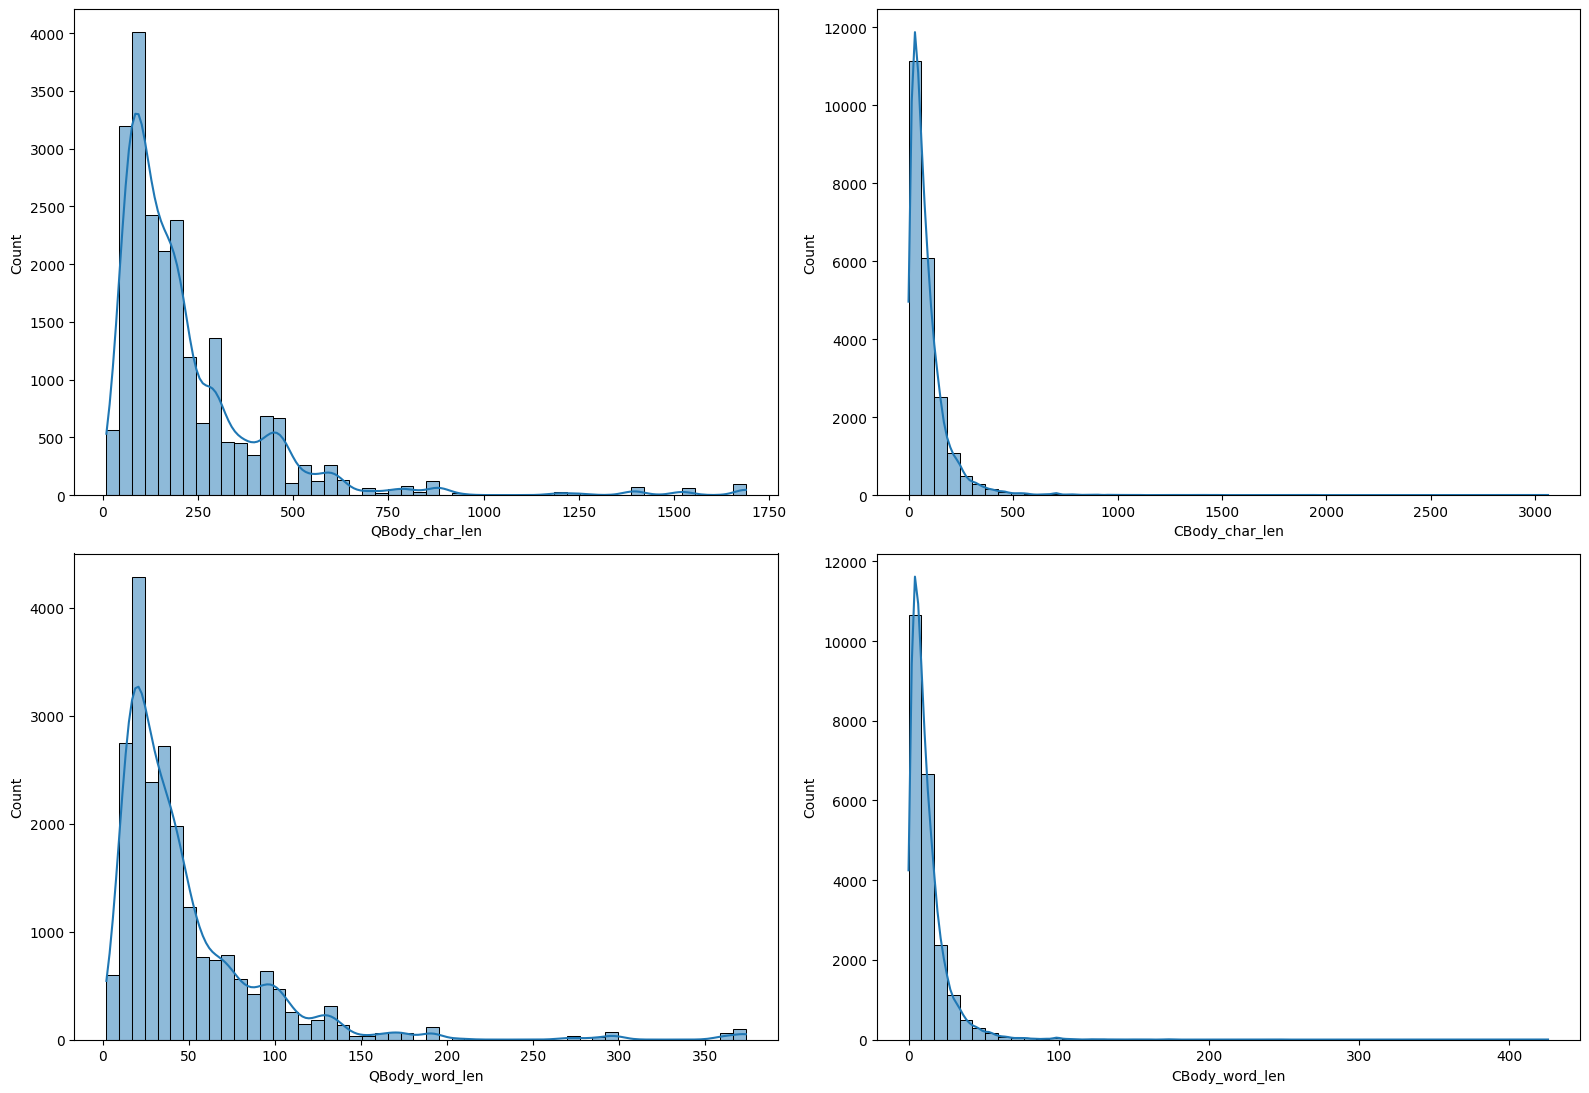

/tmp/ipython-input-2762693774.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["Questions", "Answers"])
/tmp/ipython-input-2762693774.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["Questions", "Answers"])


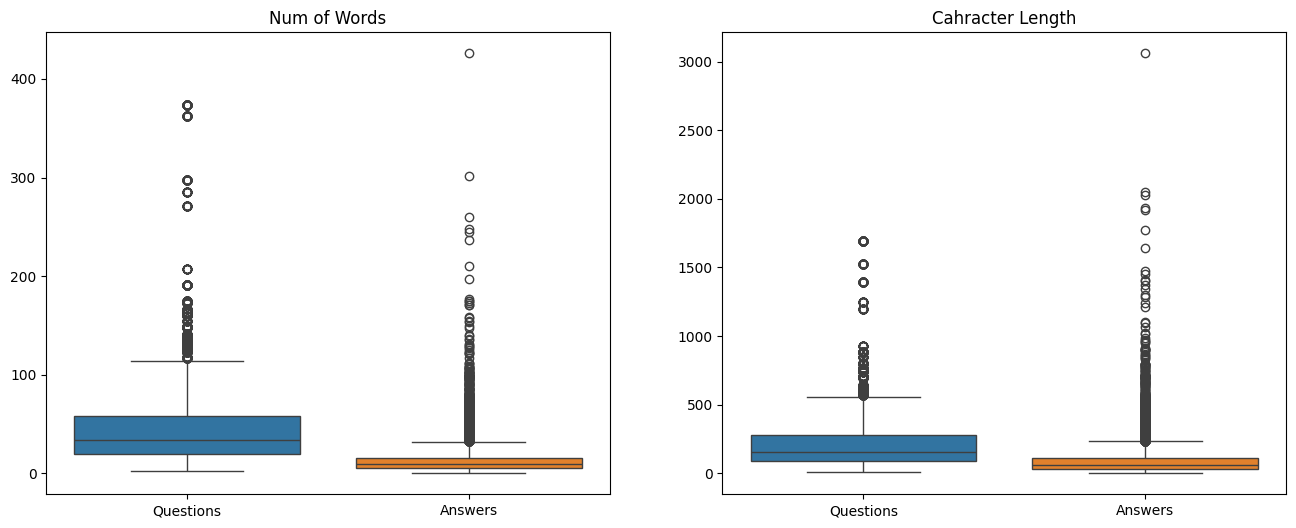

In [ ]:
plt.rcParams['font.family'] = 'DejaVu Sans'
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.histplot(df['QBody_char_len'], ax=axes[0, 0], kde=True, bins=50)

sns.histplot(df['CBody_char_len'], ax=axes[0, 1], kde=True, bins=50)

sns.histplot(df['QBody_word_len'], ax=axes[1, 0], kde=True, bins=50)

sns.histplot(df['CBody_word_len'], ax=axes[1, 1], kde=True, bins=50)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(data=df[['QBody_word_len', 'CBody_word_len']], ax=axes[0])
axes[0].set_title("Num of Words")
axes[0].set_xticklabels(["Questions", "Answers"])


sns.boxplot(data=df[['QBody_char_len', 'CBody_char_len']], ax=axes[1])
axes[1].set_title("Cahracter Length")
axes[1].set_xticklabels(["Questions", "Answers"])

plt.show()

#### Identify the most engaging questions

In [ ]:
temp_dict = {}
rows = df.shape[0]
cur_id = df["QID"].iloc[0]
num = 0
for i in range(rows):
    if df["QID"].iloc[i] != cur_id:
        temp_dict[cur_id] = [num, df["QSubject"].iloc[i-1]]
        cur_id = df["QID"].iloc[i]
        num = 0
    else:
        num += 1

In [ ]:
sorted_dict = dict(sorted(temp_dict.items(), key=lambda item: item[1][0],reverse=True))
sorted_dict

{'1556257': [314, 'ÿ®ÿß Ÿ°Ÿ• ŸÖŸäŸÑŸäŸàŸÜ ⁄ÜŸá ⁄Üÿ≤ÿß€å€å ÿ®ÿ±ÿß€å ÿ¨Ÿáÿßÿ≤ÿ™ŸàŸÜ ŸÖŸäÿÆÿ±ŸäŸÜÿü '],
 '1577970': [312, 'ÿÆŸàÿßŸÜÿØŸÜ ÿπŸÇÿØ ÿ™Ÿàÿ≥ÿ∑ ÿ≥€åÿØ ŸÖÿ≠ŸÖÿØ ÿÆÿßÿ™ŸÖ€å'],
 '1559359': [214, '⁄©€åÿß ÿ∑ŸÑÿßŸÇ ⁄Øÿ±ŸÅÿ™ŸÜ...'],
 '1555428': [214, '⁄ØŸàÿßŸá€å ÿ≥ŸÑÿßŸÖÿ™ ÿ®ÿ±ŸÖ ÿ®⁄Ø€åÿ±ŸÖ ÿü '],
 '1578477': [165, 'ÿßŸàŸÜÿß€å€å ⁄©Ÿá ÿ¥ŸàŸáÿ±ÿßÿ¥ŸàŸÜ ÿÆ€åŸÑ€å ŸÜÿßÿ≤ÿ¥ŸàŸÜŸà ŸÖ€å⁄©ÿ¥Ÿá ÿ®€åÿßŸÜ'],
 '1569562': [143, 'ŸÖ€åÿÆŸàÿßŸÖ €åŸá ⁄Ü€å ÿ®Ÿá ÿ¥ŸàŸáÿ±ŸÖ ÿ®⁄ØŸÖ ŸàŸÑ€å ŸÜŸÖ€åÿ™ŸàŸÜŸÖ.'],
 '1591164': [142, 'ÿ¥ŸàŸáÿ±ÿ™ŸàŸÜ ŸÖÿßÿ¥€åŸÜ ÿ®ÿÆÿ±Ÿá ÿ®Ÿá ŸÜÿßŸÖÿ™ŸàŸÜ ŸÜÿ≤ŸÜŸá ŸÜÿßÿ±ÿßÿ≠ÿ™ ŸÖ€åÿ¥€åÿØÿü'],
 '1585904': [136, 'ÿÆŸàÿßÿ≥ÿ™ŸÖ ÿ®Ÿá ÿÆŸàÿßÿ≥ÿ™⁄Øÿßÿ±ŸÖ ÿ®⁄ØŸÖ ÿ®€åŸÖÿßÿ±€å ÿØÿßÿ±ŸÖ ÿßŸÖÿß....'],
 '1567278': [136, 'ÿÆŸàÿßÿ≥ÿ™⁄Øÿßÿ±'],
 '1575297': [135, 'ÿ®€åÿß€åŸÜ ÿ®⁄Ø€åŸÜ ⁄Ü⁄©ÿßÿ±⁄©ŸÜŸÖ ÿ®ÿßÿ¥ŸàŸáÿ±ŸÖ'],
 '1554952': [128, 'ÿ®ÿß ŸÜÿßŸÖÿ≤ÿØŸÖ ÿØÿπŸàÿßŸÖ ÿ¥ÿØŸá.ÿµÿØÿßŸÖ ÿ±Ÿà ÿ∂ÿ®ÿ∑ ⁄©ÿ±ÿØŸá'],
 '1555344': [124, 'ÿÆŸàÿßÿ≥ÿ™⁄Øÿßÿ±€åŸÖ ŸÜÿ≤ÿØ€å⁄©Ÿá ÿßÿ≥ÿ™ÿ±ÿ≥ ÿØÿßÿ±ŸÖ. '],
 '1564216': [118, 'ÿ®⁄©ÿß

#### Analyze user activity patterns

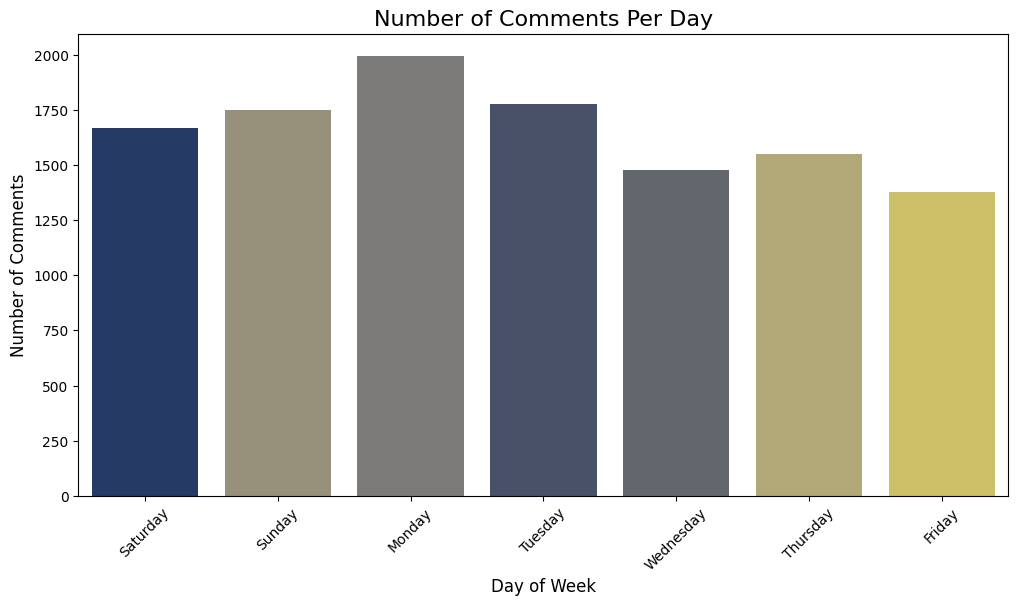

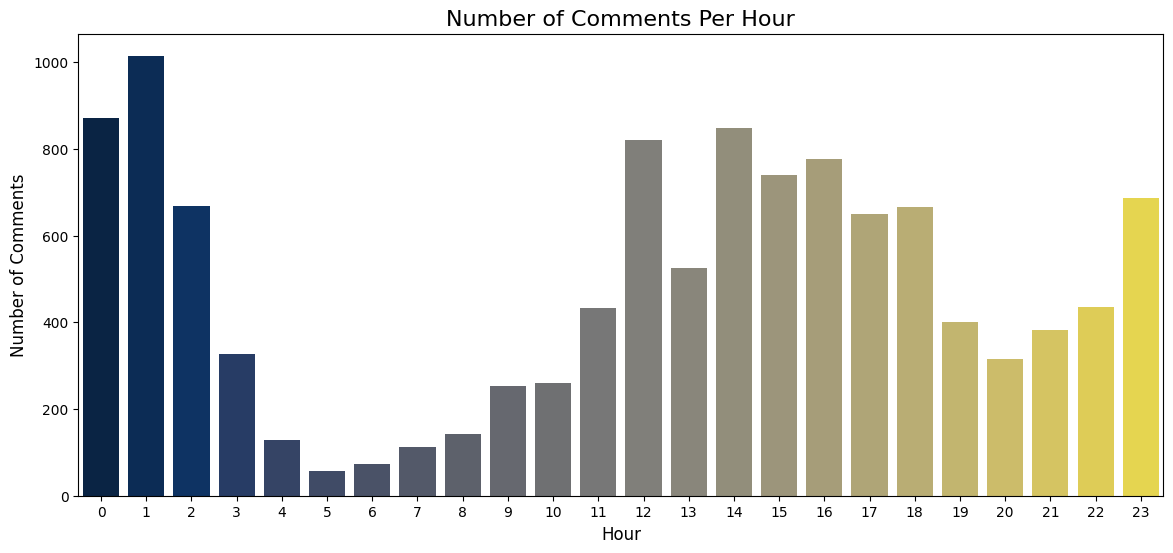

In [ ]:
df['CDate'] = pd.to_datetime(df['CDate'], errors='coerce')
df_activity = df.dropna(subset=['CDate']).copy()
df_activity.loc[:, 'DayOfWeek'] = df_activity['CDate'].dt.day_name()
df_activity.loc[:, 'Hour'] = df_activity['CDate'].dt.hour
day_order = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

plt.figure(figsize=(12, 6))
sns.countplot(x='DayOfWeek', data=df_activity, order=day_order, palette='cividis', hue='DayOfWeek', legend=False)
plt.title("Number of Comments Per Day", fontsize=16)
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("Number of Comments", fontsize=12)
plt.xticks(ticks=range(7), labels=day_order, rotation=45)
plt.show()

plt.figure(figsize=(14, 6))
sns.countplot(x='Hour', data=df_activity, palette='cividis', hue='Hour', legend=False)
plt.title("Number of Comments Per Hour", fontsize=16)
plt.xlabel("Hour", fontsize=12)
plt.ylabel("Number of Comments", fontsize=12)
plt.show()

#### Detect top answer contributors

In [ ]:
answer_counts = df['CUsername'].value_counts().reset_index()
answer_counts.columns = ['CUsername', 'AnswerCount']
answer_counts

CUsername  AnswerCount
0     ÿ®ÿßÿ±ÿßŸÜ_ÿ®Ÿáÿßÿ±€å95          142
1        ÿ®ŸÑŸàÿ®ÿ±€å€≥€≤€≥€∑           96
2           a_rezoo           93
3          saghiiii           89
4          ÿπÿ≥ŸÑ€åk516           86
...             ...          ...
6278     ŸÖÿßŸÖÿßŸÜ_ÿßÿ≥ÿ±ÿß            1
6279      abremaman            1
6280            mzf            1
6281        ŸÑ€åÿßÿßŸÜÿßÿß            1
6282        mahboub            1

[6283 rows x 2 columns]

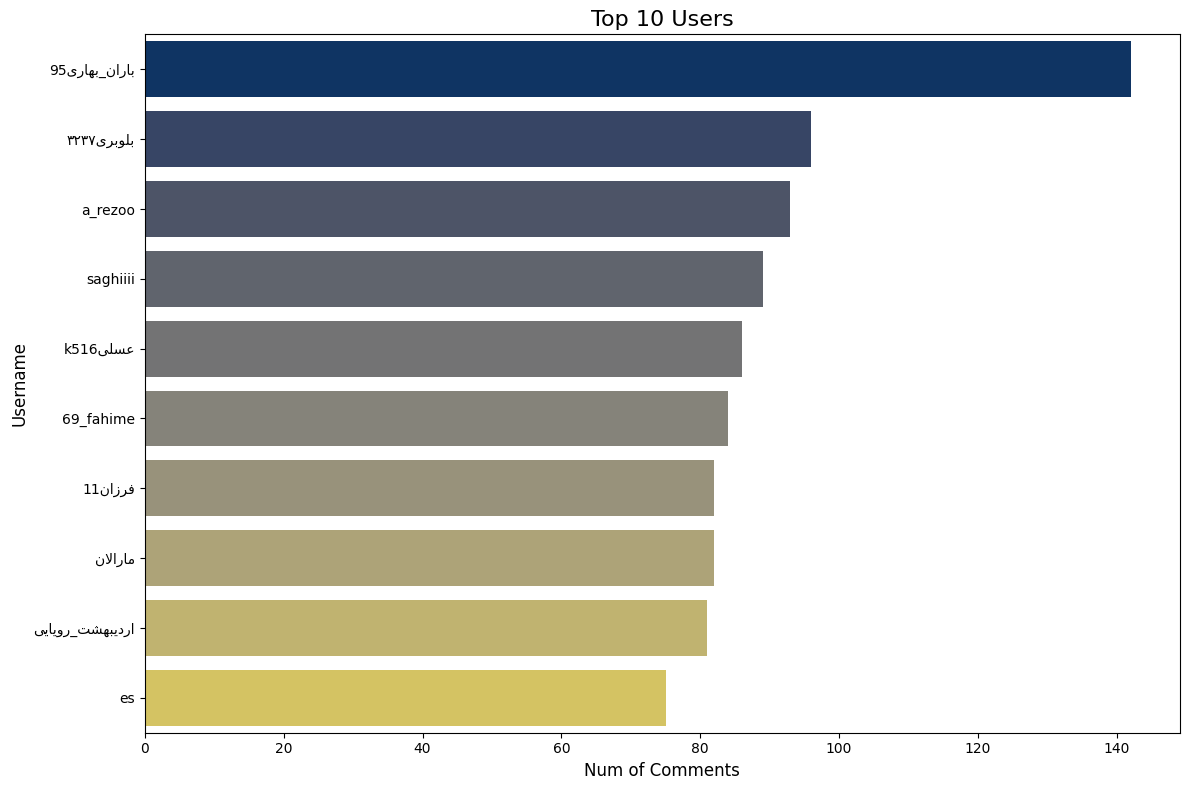

In [ ]:
top_contributors = answer_counts.sort_values(by='AnswerCount', ascending=False)
top_n = 10
plt.figure(figsize=(12, 8))
chart_labels = top_contributors['CUsername'].head(top_n).apply(correct_persian_display)
chart_counts = top_contributors['AnswerCount'].head(top_n)

sns.barplot(x=chart_counts, y=chart_labels, palette='cividis', hue=chart_labels, legend=False)
plt.title("Top 10 Users", fontsize=16)
plt.xlabel("Num of Comments", fontsize=12)
plt.ylabel("Username", fontsize=12)
plt.tight_layout()
plt.show()

#### Linguistic and word-level analysis

In [ ]:
persian_stopwords = set(stopwords_list())
all_question_tokens = [token for sublist in df['QBody_tokenized'] for token in sublist]
all_answer_tokens = [token for sublist in df['CBody_formalized'] for token in sublist]
question_tokens_no_stops = [token for token in all_question_tokens if token not in persian_stopwords]
answer_tokens_no_stops = [token for token in all_answer_tokens if token not in persian_stopwords]

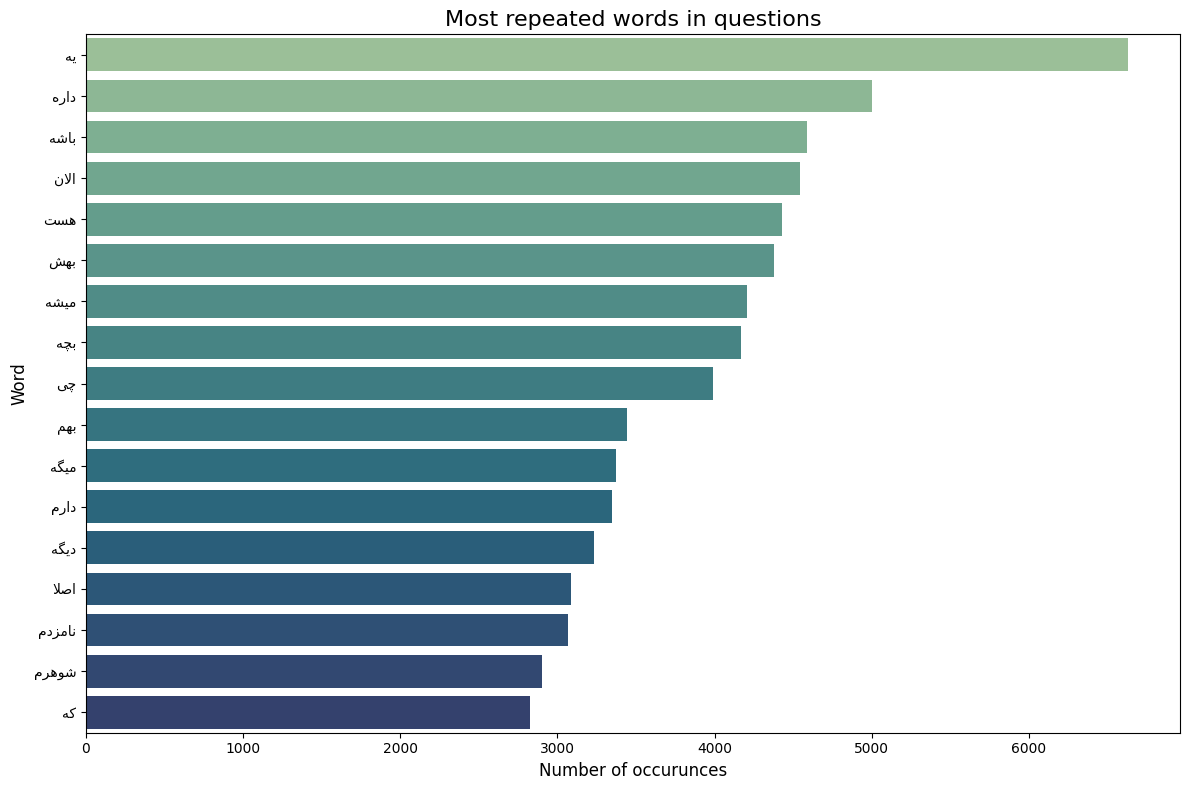

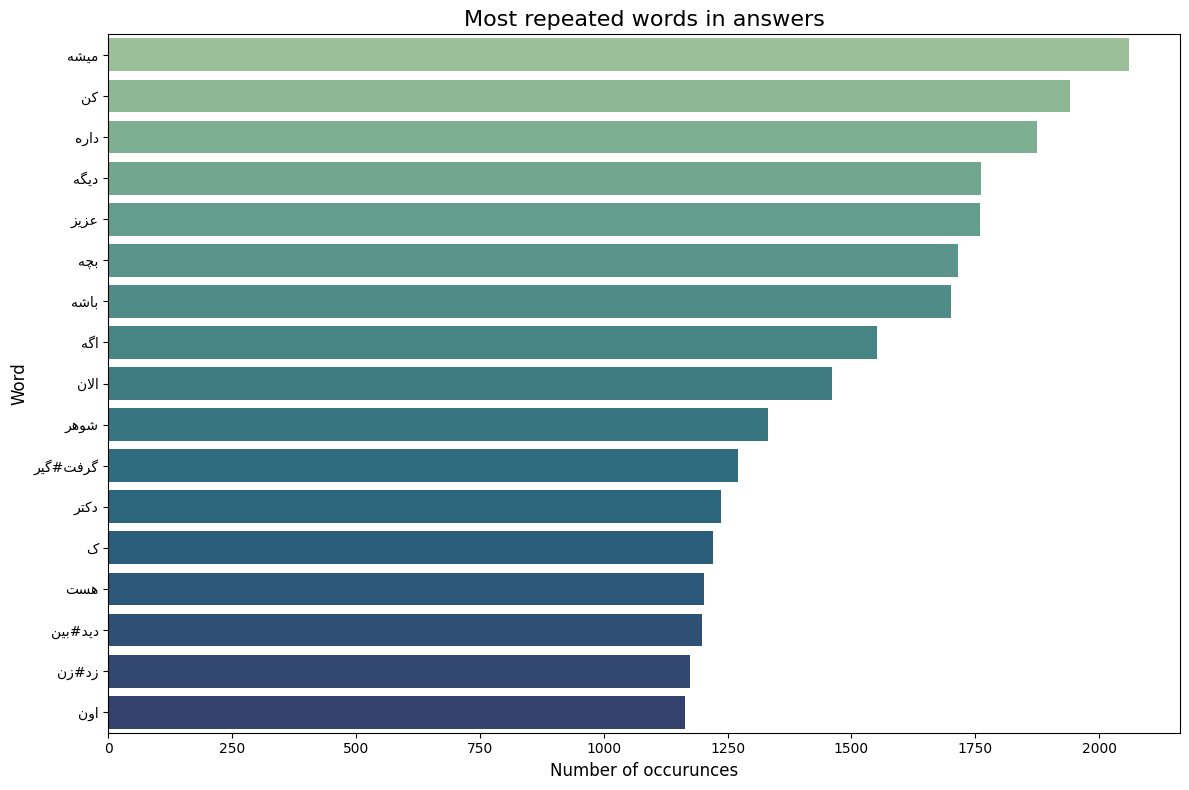

In [ ]:
def correct_persian_display(text):
    reshaped_text = arabic_reshaper.reshape(text)
    return get_display(reshaped_text)
def plot_word_frequency(tokens, title, top_k=20):
    word_counts = Counter(tokens)
    top_words = word_counts.most_common(top_k)
    words = [word for word, count in top_words[3:]]
    counts = [count for word, count in top_words[3:]]
    persian_labels = [correct_persian_display(word) for word in words]
    plt.figure(figsize=(12, 8))
    sns.barplot(x=counts, y=persian_labels, palette='crest', hue=persian_labels, legend=False)
    plt.title(title, fontsize=16)
    plt.xlabel("Number of occurunces", fontsize=12)
    plt.ylabel("Word", fontsize=12)
    plt.tight_layout()
    plt.show()

plot_word_frequency(question_tokens_no_stops, "Most repeated words in questions")
plot_word_frequency(answer_tokens_no_stops, "Most repeated words in answers")

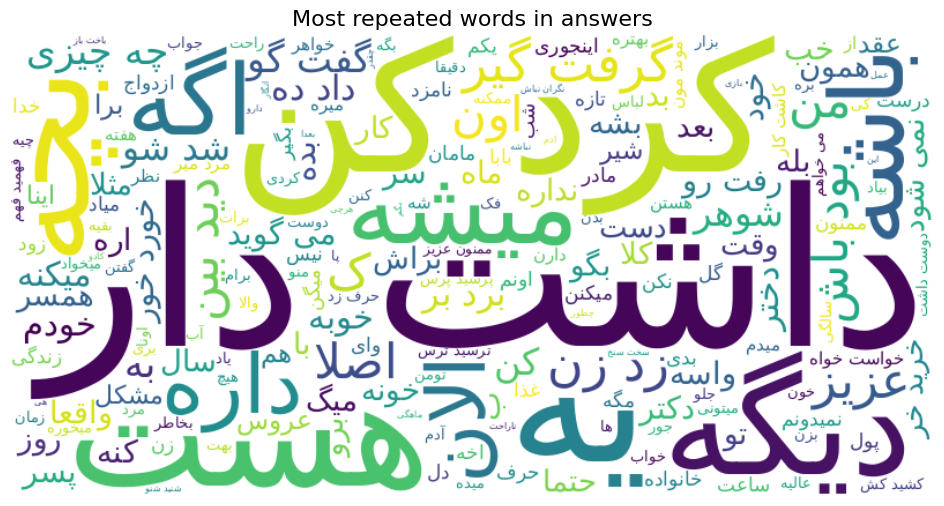

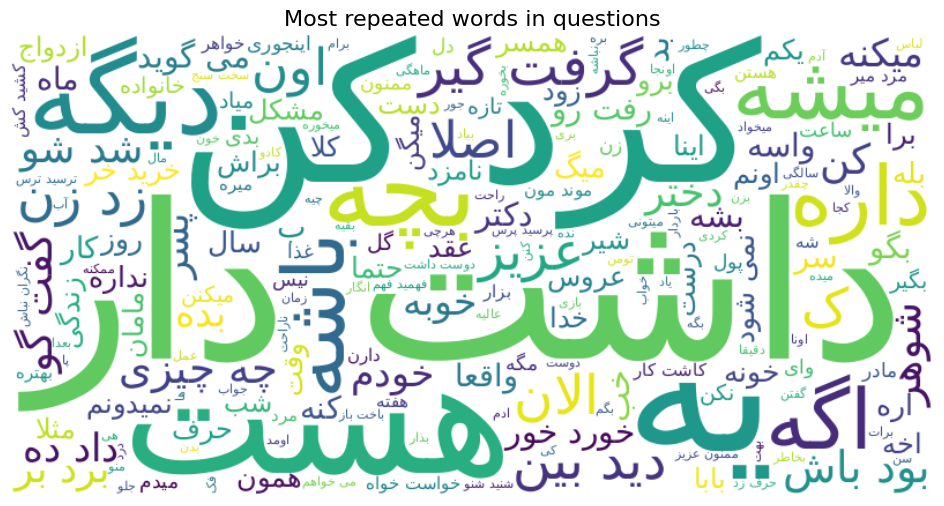

In [ ]:
def generate_wordcloud(tokens, title):
    text = " ".join(tokens)
    reshaped_text = arabic_reshaper.reshape(text)
    font_path = './DejaVuSans.ttf'

    wordcloud = WordCloud(
        font_path=font_path,
        width=800,
        height=400,
        background_color='white'
    ).generate(reshaped_text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

generate_wordcloud(all_answer_tokens, "Most repeated words in answers")
generate_wordcloud(answer_tokens_no_stops, "Most repeated words in questions")

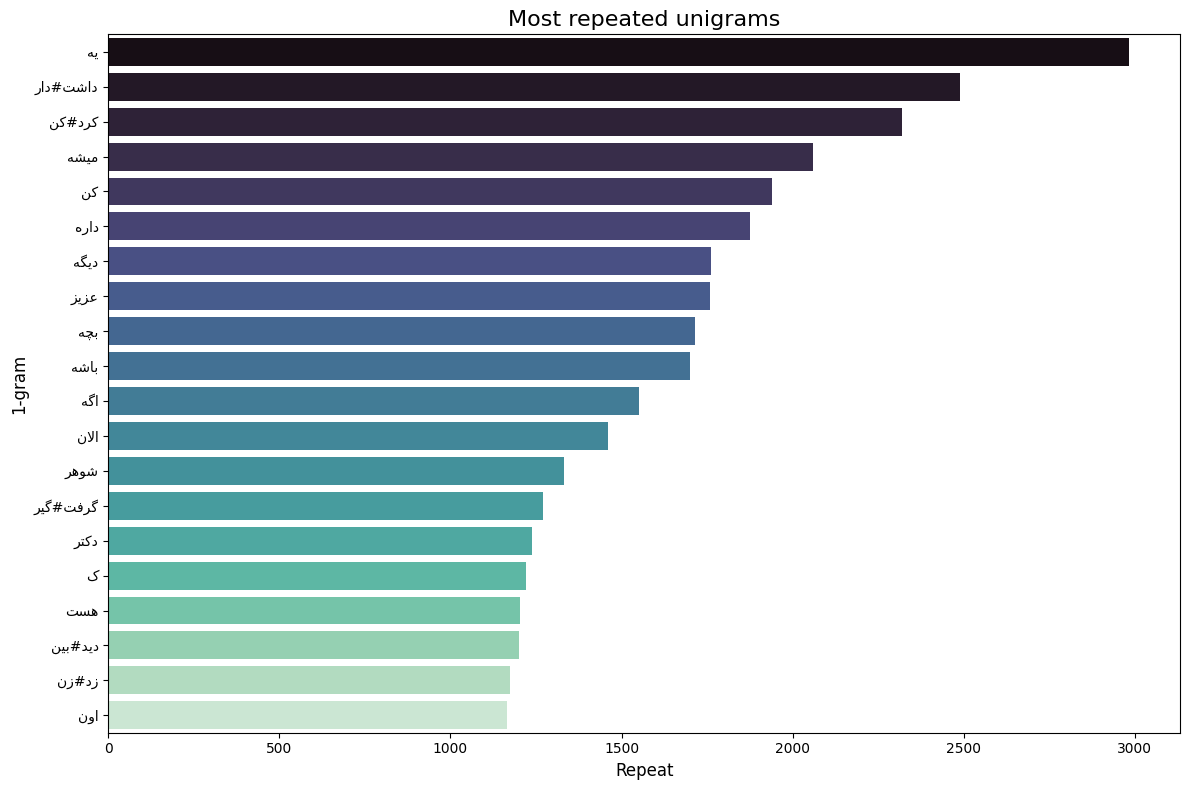

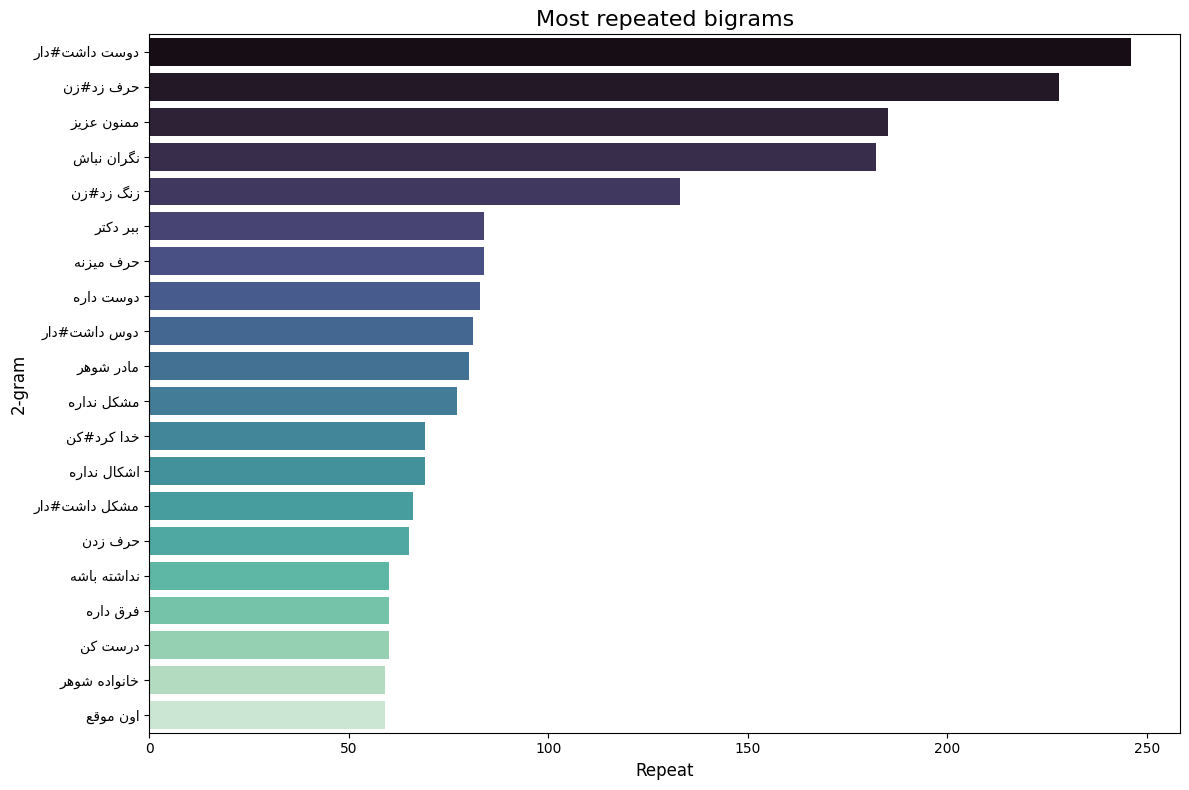

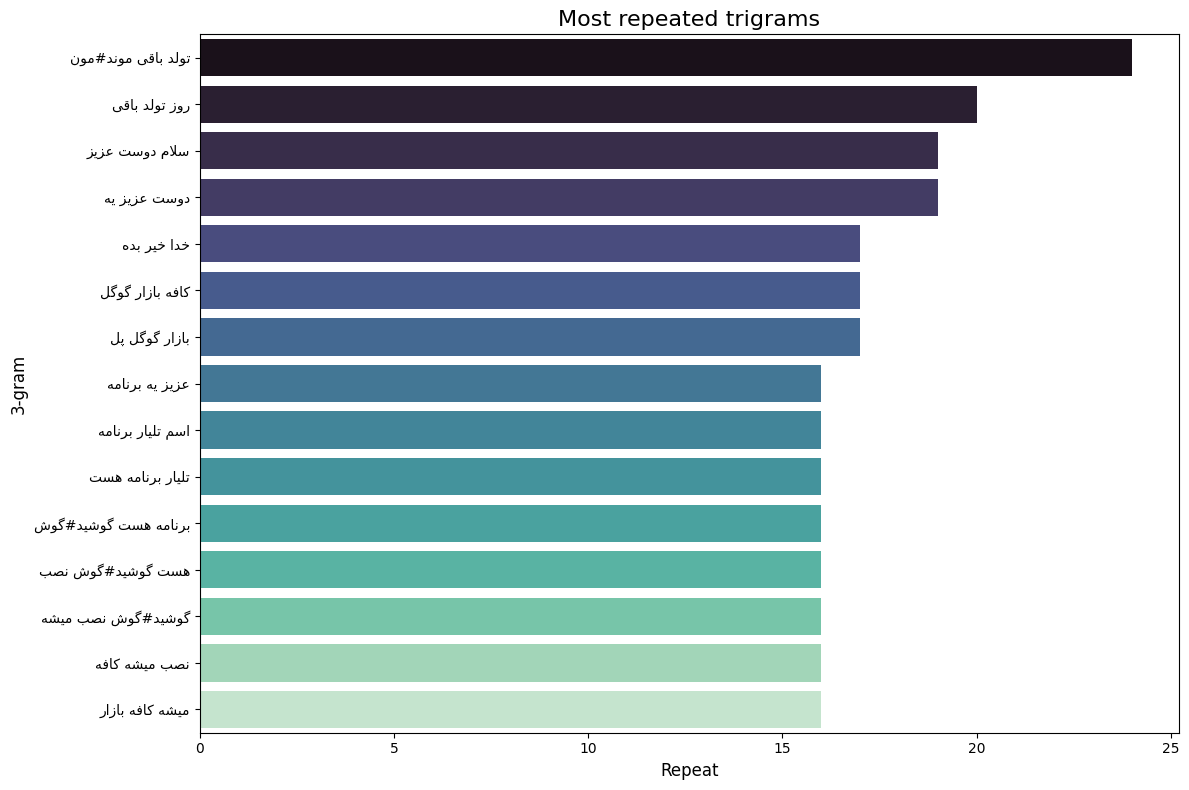

In [ ]:
def plot_top_ngrams(tokens, title, n=2, top_k=15):
    n_grams = ngrams(tokens, n)
    n_gram_counts = Counter(n_grams)

    top_ngrams = n_gram_counts.most_common(top_k)

    ngram_labels = [" ".join(gram) for gram, count in top_ngrams]
    ngram_counts = [count for gram, count in top_ngrams]

    persian_labels = [correct_persian_display(label) for label in ngram_labels]
    plt.figure(figsize=(12, 8))
    sns.barplot(x=ngram_counts, y=persian_labels, palette='mako', hue=persian_labels, legend=False)
    plt.title(correct_persian_display(title), fontsize=16)
    plt.xlabel(correct_persian_display("Repeat"), fontsize=12)
    plt.ylabel(correct_persian_display(f"{n}-gram"), fontsize=12)
    plt.tight_layout()
    plt.show()

plot_top_ngrams(answer_tokens_no_stops, "Most repeated unigrams", n=1, top_k=20)
plot_top_ngrams(answer_tokens_no_stops, "Most repeated bigrams", n=2, top_k=20)
plot_top_ngrams(answer_tokens_no_stops, "Most repeated trigrams", n=3, top_k=15)

## Analyse the dataset

In [5]:
df_2 = pd.read_json("./PerCQA_JSON_Format.json", encoding='utf-8-sig')
df_2.head()

QID  QCATEGORY                QDATE  QUSERID    QTYPE        QGOLD_YN  \
0  1550088        NaN  2018-01-01T12:14:00     9101  General  Not Applicable   
1  1558609        NaN  2018-01-06T00:17:00     6856  General  Not Applicable   
2  1587820        NaN  2018-01-22T13:23:00     9918  General  Not Applicable   
3  4414921        NaN  2020-05-23T02:06:00    81403  General  Not Applicable   
4  3109668        NaN  2019-08-13T12:07:00    25700  General  Not Applicable   

    QUsername                                              QBody  \
0    sami1366  ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄Ü...   
1  khanoomi72  ŸÖŸÜ ÿÆŸàÿØŸÖ ÿ≠ÿ≥ ŸÖ€å⁄©ŸÜŸÖ ÿßÿ¥ÿ™ÿ®ÿßŸáŸÖ ⁄Ø€åÿ± ÿØÿßÿØŸÜ ÿ®€åÿÆŸàÿØ€å Ÿà ÿ∫ÿ± ...   
2         lol  ÿ≥ÿßŸÑ⁄Øÿ±ÿØ ÿßÿ≤ÿØŸàÿßÿ¨ŸÖ ŸÜÿ≤ÿØ€å⁄©Ÿá ⁄Ü€å ÿ®ÿÆÿ±ŸÖ. ÿ≥ÿßŸÑ⁄Øÿ±ÿØ ÿØŸàŸÖŸÖŸàŸÜŸá....   
3  sepide1400  ÿØÿÆÿ™ÿ± ŸÖŸÜ ⁄ÜŸáÿßÿ±ÿØŸá ŸÖÿßŸáŸá ÿßÿ≥ÿ™. ÿ¢€åÿß ÿ®ÿ±ÿß€å ÿ™ÿ¥ÿÆ€åÿµ Ÿæÿ±ÿßŸÜÿ™ÿ≤...   
4       ŸÜÿ≥ÿß€∑€π   ⁄ÜŸá ŸæŸÖÿßÿØ€å ÿ®ÿ≤ŸÜŸÖ Ÿà ÿßÿ≤ ⁄Ü€åŸá ÿß€åŸÜÿ¨Ÿàÿ± ÿ¥ÿØŸá  . Ÿàÿßÿ∂ÿ≠ ŸÜ€åÿ≥...   

                                    QSubject  \
0                                 ŸÇŸáÿ± ÿ¥ŸàŸáÿ±ŸÖ    
1  ÿ®ÿ≤ÿ±⁄Øÿ™ÿ±€åŸÜ ÿßÿ¥ÿ™ÿ®ÿßŸá ÿØŸàÿ±ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØ€åÿ™ŸàŸÜ ⁄Ü€å ÿ®ŸàÿØŸáÿüÿü   
2                  ⁄©ŸÖ⁄© ÿ≥ÿßŸÑ⁄Øÿ±ÿØ ÿßÿ≤ÿØŸàÿßÿ¨ŸÖ ŸÜÿ≤ÿØ€å⁄©Ÿá   
3        ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàŸæÿØ€å ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ Ÿæÿ±ÿßŸÜÿ™ÿ≤€å Ÿæÿß   
4                      ŸÑŸæ Ÿæÿ≥ÿ±ŸÖ ŸÇÿ±ŸÖÿ≤ ÿØŸàŸÜ ÿØŸàŸÜŸá   

                                            Comments  
0  [{'CID': '50758322', 'CUSERID': 4918, 'CGOLD':...  
1  [{'CID': '51114707', 'CUSERID': 3935, 'CGOLD':...  
2  [{'CID': '52336355', 'CUSERID': 10255, 'CGOLD'...  
3  [{'CID': '138006316', 'CUSERID': 38437, 'CGOLD...  
4  [{'CID': '100859930', 'CUSERID': 33391, 'CGOLD...

In [6]:
df_2 = df_2.dropna(subset=['QBody']).reset_index(drop=True)

In [7]:
df_2 = df_2.dropna(subset=['QID']).reset_index(drop=True)

In [8]:
df_2 = df_2.rename(columns={"QBody": "qbody", "QID": "qid"})

In [9]:
df_2.head()

qid  QCATEGORY                QDATE  QUSERID    QTYPE        QGOLD_YN  \
0  1550088        NaN  2018-01-01T12:14:00     9101  General  Not Applicable   
1  1558609        NaN  2018-01-06T00:17:00     6856  General  Not Applicable   
2  1587820        NaN  2018-01-22T13:23:00     9918  General  Not Applicable   
3  4414921        NaN  2020-05-23T02:06:00    81403  General  Not Applicable   
4  3109668        NaN  2019-08-13T12:07:00    25700  General  Not Applicable   

    QUsername                                              qbody  \
0    sami1366  ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄Ü...   
1  khanoomi72  ŸÖŸÜ ÿÆŸàÿØŸÖ ÿ≠ÿ≥ ŸÖ€å⁄©ŸÜŸÖ ÿßÿ¥ÿ™ÿ®ÿßŸáŸÖ ⁄Ø€åÿ± ÿØÿßÿØŸÜ ÿ®€åÿÆŸàÿØ€å Ÿà ÿ∫ÿ± ...   
2         lol  ÿ≥ÿßŸÑ⁄Øÿ±ÿØ ÿßÿ≤ÿØŸàÿßÿ¨ŸÖ ŸÜÿ≤ÿØ€å⁄©Ÿá ⁄Ü€å ÿ®ÿÆÿ±ŸÖ. ÿ≥ÿßŸÑ⁄Øÿ±ÿØ ÿØŸàŸÖŸÖŸàŸÜŸá....   
3  sepide1400  ÿØÿÆÿ™ÿ± ŸÖŸÜ ⁄ÜŸáÿßÿ±ÿØŸá ŸÖÿßŸáŸá ÿßÿ≥ÿ™. ÿ¢€åÿß ÿ®ÿ±ÿß€å ÿ™ÿ¥ÿÆ€åÿµ Ÿæÿ±ÿßŸÜÿ™ÿ≤...   
4       ŸÜÿ≥ÿß€∑€π   ⁄ÜŸá ŸæŸÖÿßÿØ€å ÿ®ÿ≤ŸÜŸÖ Ÿà ÿßÿ≤ ⁄Ü€åŸá ÿß€åŸÜÿ¨Ÿàÿ± ÿ¥ÿØŸá  . Ÿàÿßÿ∂ÿ≠ ŸÜ€åÿ≥...   

                                    QSubject  \
0                                 ŸÇŸáÿ± ÿ¥ŸàŸáÿ±ŸÖ    
1  ÿ®ÿ≤ÿ±⁄Øÿ™ÿ±€åŸÜ ÿßÿ¥ÿ™ÿ®ÿßŸá ÿØŸàÿ±ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØ€åÿ™ŸàŸÜ ⁄Ü€å ÿ®ŸàÿØŸáÿüÿü   
2                  ⁄©ŸÖ⁄© ÿ≥ÿßŸÑ⁄Øÿ±ÿØ ÿßÿ≤ÿØŸàÿßÿ¨ŸÖ ŸÜÿ≤ÿØ€å⁄©Ÿá   
3        ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàŸæÿØ€å ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ Ÿæÿ±ÿßŸÜÿ™ÿ≤€å Ÿæÿß   
4                      ŸÑŸæ Ÿæÿ≥ÿ±ŸÖ ŸÇÿ±ŸÖÿ≤ ÿØŸàŸÜ ÿØŸàŸÜŸá   

                                            Comments  
0  [{'CID': '50758322', 'CUSERID': 4918, 'CGOLD':...  
1  [{'CID': '51114707', 'CUSERID': 3935, 'CGOLD':...  
2  [{'CID': '52336355', 'CUSERID': 10255, 'CGOLD'...  
3  [{'CID': '138006316', 'CUSERID': 38437, 'CGOLD...  
4  [{'CID': '100859930', 'CUSERID': 33391, 'CGOLD...

### Load the bge-m3 embedding model and test it.

In [10]:
model = SentenceTransformer('BAAI/bge-m3')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [11]:
random_question_text = df_2['qbody'].dropna().sample(1).iloc[0]
print(f"Original Text: {random_question_text}")

Original Text: ÿ®⁄ÜŸÖ €åŸáŸà ŸÖ€åÿßÿØ ŸÖŸàŸáÿßŸÖ ÿ±Ÿà ŸÖ€å⁄©ÿ¥Ÿá. ŸÜŸÖ€åÿØŸàŸÜŸÖ ⁄Ü€å⁄©ÿßÿ± ⁄©ŸÜŸÖÿü  ⁄Üÿ±ÿß ÿß€åŸÜ⁄©ÿßÿ±Ÿà ŸÖ€å⁄©ŸÜŸá ÿü


In [12]:
question_embedding = model.encode(random_question_text)

In [13]:
print(f"Type of the output: {type(question_embedding)}")
print(f"Shape of the embedding vector: {question_embedding.shape}")
print(f"First 5 elements of the vector: {question_embedding[:5]}")

Type of the output: <class 'numpy.ndarray'>
Shape of the embedding vector: (1024,)
First 5 elements of the vector: [-0.02326235  0.01962654 -0.04125646 -0.04031299 -0.03371288]


**What does it return?**

The model.encode() function returns a dense vector embedding. This is a one-dimensional array of numbers (a numpy.ndarray). For the bge-m3 model, this vector has a specific size (1024 dimensions).

**What do the components of the output represent?**

The vector itself is a high-dimensional numerical representation of the input text's meaning. Each number (or "component") in the vector represents a learned feature of the text's semantics. It's important to understand that a single component does not have a human-interpretable meaning (e.g., the 5th element doesn't represent "sports"). Instead, the entire vector as a whole captures the text's position in a "semantic space." Texts with similar meanings will have vectors that are close to each other in this space.

**Potential Uses:**

**Semantic Search**: This is the primary use for our project. By converting a user's query and all the questions in our database into these vectors, we can find the questions whose vectors are mathematically closest to the query's vector (using measures like cosine similarity). This finds results based on meaning, not just keywords.

**Clustering**: We can group similar questions together by clustering their embedding vectors.

**Classification**: The embeddings can be used as features to train a machine learning model for tasks like topic classification.

**Reranking**: As mentioned in out project description, we can use these embeddings to re-rank results from a keyword search to improve relevance.

### Install LanceDB and set up an embedding function

In [14]:
@register("bge_m3_dense")
class BGE_M3_Dense(TextEmbeddingFunction):
    _model: BGEM3FlagModel = PrivateAttr()
    def __init__(self):
        super().__init__()
        self._model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True)

    def generate_embeddings(self, texts):
        embeddings_dict = self._model.encode(texts, return_dense=True)
        return embeddings_dict['dense_vecs'].tolist()

    def ndims(self):
        return 1024

registry = EmbeddingFunctionRegistry.get_instance()
bge = registry.get("bge_m3_dense").create()

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

long.jpg:   0%|          | 0.00/485k [00:00<?, ?B/s]

.DS_Store:   0%|          | 0.00/6.15k [00:00<?, ?B/s]

bm25.jpg:   0%|          | 0.00/132k [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

miracl.jpg:   0%|          | 0.00/576k [00:00<?, ?B/s]

colbert_linear.pt:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

nqa.jpg:   0%|          | 0.00/158k [00:00<?, ?B/s]

mkqa.jpg:   0%|          | 0.00/608k [00:00<?, ?B/s]

Constant_7_attr__value:   0%|          | 0.00/65.6k [00:00<?, ?B/s]

others.webp:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

long.jpg:   0%|          | 0.00/127k [00:00<?, ?B/s]

model.onnx_data:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/725k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/698 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

sparse_linear.pt:   0%|          | 0.00/3.52k [00:00<?, ?B/s]

### Define a schema for our vector database

In [15]:
class NiniSiteQuestions(LanceModel):
    qid: str
    qbody: str = bge.SourceField()
    embedding: Vector(bge.ndims()) = bge.VectorField()

In [16]:
print("--- LanceDB Schema Definition ---\n")
print(NiniSiteQuestions.schema())

--- LanceDB Schema Definition ---

{'properties': {'qid': {'title': 'Qid', 'type': 'string'}, 'qbody': {'source_column_for': {'max_retries': 7}, 'title': 'Qbody', 'type': 'string'}, 'embedding': {'items': {'type': 'number'}, 'maxItems': 1024, 'minItems': 1024, 'title': 'Embedding', 'type': 'array', 'vector_column_for': {'max_retries': 7}}}, 'required': ['qid', 'qbody', 'embedding'], 'title': 'NiniSiteQuestions', 'type': 'object'}


/tmp/ipython-input-1413586637.py:2: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  print(NiniSiteQuestions.schema())


### Create and populate a LanceDB table.

In [17]:
db = lancedb.connect("./lancedb")
questions_data = df_2[['qid', 'qbody']].drop_duplicates().reset_index(drop=True)

In [18]:
questions_data

qid                                              qbody
0    1550088  ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄Ü...
1    1558609  ŸÖŸÜ ÿÆŸàÿØŸÖ ÿ≠ÿ≥ ŸÖ€å⁄©ŸÜŸÖ ÿßÿ¥ÿ™ÿ®ÿßŸáŸÖ ⁄Ø€åÿ± ÿØÿßÿØŸÜ ÿ®€åÿÆŸàÿØ€å Ÿà ÿ∫ÿ± ...
2    1587820  ÿ≥ÿßŸÑ⁄Øÿ±ÿØ ÿßÿ≤ÿØŸàÿßÿ¨ŸÖ ŸÜÿ≤ÿØ€å⁄©Ÿá ⁄Ü€å ÿ®ÿÆÿ±ŸÖ. ÿ≥ÿßŸÑ⁄Øÿ±ÿØ ÿØŸàŸÖŸÖŸàŸÜŸá....
3    4414921  ÿØÿÆÿ™ÿ± ŸÖŸÜ ⁄ÜŸáÿßÿ±ÿØŸá ŸÖÿßŸáŸá ÿßÿ≥ÿ™. ÿ¢€åÿß ÿ®ÿ±ÿß€å ÿ™ÿ¥ÿÆ€åÿµ Ÿæÿ±ÿßŸÜÿ™ÿ≤...
4    3109668   ⁄ÜŸá ŸæŸÖÿßÿØ€å ÿ®ÿ≤ŸÜŸÖ Ÿà ÿßÿ≤ ⁄Ü€åŸá ÿß€åŸÜÿ¨Ÿàÿ± ÿ¥ÿØŸá  . Ÿàÿßÿ∂ÿ≠ ŸÜ€åÿ≥...
..       ...                                                ...
985  1582862  ŸáÿØÿß€åÿß€å€å ⁄©Ÿá ÿ®ÿ±ÿß€å ÿ®ŸÑŸá ÿ®ÿ±ŸàŸÜ ŸÖ€å ÿ®ÿ±ŸÜ ÿ™Ÿà ÿ¥Ÿáÿ±Ÿáÿß€å ŸÖÿÆÿ™ŸÑ...
986  1790522  ÿ®ÿ±ÿßŸä ÿßŸàŸÑŸäŸÜ ÿ®ÿßÿ± ŸÉÿ±Ÿá Ÿä ÿ®ÿßÿØŸàŸÖ ÿ≤ŸÖŸäŸÜŸä ÿÆÿ±ŸäÿØŸÖ ŸàŸÑŸä ŸÜŸÖŸä...
987  1574016  ŸÖŸÜ €πŸÖÿßŸáŸá ⁄©Ÿá ÿπŸÇÿØ ⁄©ÿ±ÿØŸÖ . ŸÜÿßŸÖÿ≤ÿØŸÖ ŸÖÿßŸá€å€±€±€∞€∞ÿ≠ŸÇŸàŸÇÿ¥Ÿá ÿ™...
988  4171615  ÿ®⁄ÜŸá Ÿáÿß ÿßÿ≤ ⁄©€å ÿ®Ÿá ŸÜÿ®ŸàÿØŸÜ ÿ¥€åÿ± ÿπÿßÿØÿ™ ŸÖ€å⁄©ŸÜŸÜÿü €≥ ÿ±Ÿàÿ≤Ÿá ⁄Ø...
989  1571432  ÿ≥ŸÑÿßŸÖ ÿÆÿØŸÖÿ™ ⁄©ÿßÿ±ÿ®ÿ±ÿßŸÜ ŸÖÿ≠ÿ™ÿ±ŸÖ. ŸÖŸÜ ŸÇÿµÿØ ÿØÿßÿ±ŸÖ ÿ®Ÿá ÿÆŸàÿßÿ≥ÿ™⁄Ø...

[990 rows x 2 columns]

In [19]:
data_to_add = questions_data.to_dict('records')

In [20]:
table_name = "nini_questions"
if table_name in db.table_names():
    db.drop_table(table_name)
tbl = db.create_table(table_name, schema=NiniSiteQuestions)

In [21]:
tbl.add(data_to_add)
print("Data has been added and embeddings have been generated successfully!")

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

pre tokenize: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:00<00:00, 29.91it/s]
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Inference Embeddings: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:08<00:00,  2.17s/it]


Data has been added and embeddings have been generated successfully!


In [22]:
print(f"\nNumber of rows in the new table: {len(tbl)}")
print("\nSample of data from the table:")
print(tbl.head(5).to_pandas())


Number of rows in the new table: 990

Sample of data from the table:
       qid                                              qbody  \
0  1550088  ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄Ü...   
1  1558609  ŸÖŸÜ ÿÆŸàÿØŸÖ ÿ≠ÿ≥ ŸÖ€å⁄©ŸÜŸÖ ÿßÿ¥ÿ™ÿ®ÿßŸáŸÖ ⁄Ø€åÿ± ÿØÿßÿØŸÜ ÿ®€åÿÆŸàÿØ€å Ÿà ÿ∫ÿ± ...   
2  1587820  ÿ≥ÿßŸÑ⁄Øÿ±ÿØ ÿßÿ≤ÿØŸàÿßÿ¨ŸÖ ŸÜÿ≤ÿØ€å⁄©Ÿá ⁄Ü€å ÿ®ÿÆÿ±ŸÖ. ÿ≥ÿßŸÑ⁄Øÿ±ÿØ ÿØŸàŸÖŸÖŸàŸÜŸá....   
3  4414921  ÿØÿÆÿ™ÿ± ŸÖŸÜ ⁄ÜŸáÿßÿ±ÿØŸá ŸÖÿßŸáŸá ÿßÿ≥ÿ™. ÿ¢€åÿß ÿ®ÿ±ÿß€å ÿ™ÿ¥ÿÆ€åÿµ Ÿæÿ±ÿßŸÜÿ™ÿ≤...   
4  3109668   ⁄ÜŸá ŸæŸÖÿßÿØ€å ÿ®ÿ≤ŸÜŸÖ Ÿà ÿßÿ≤ ⁄Ü€åŸá ÿß€åŸÜÿ¨Ÿàÿ± ÿ¥ÿØŸá  . Ÿàÿßÿ∂ÿ≠ ŸÜ€åÿ≥...   

                                           embedding  
0  [0.04397583, 0.036621094, -0.01058197, -0.0099...  
1  [-0.037750244, -0.0014886856, -0.030914307, -0...  
2  [-0.029922485, 0.06732178, -0.038208008, 0.036...  
3  [-0.031036377, 0.018676758, -0.044403076, 0.01...  
4  [-0.01689148, 0.03353882, -0.06298828, 0.00142...  


In [23]:
# Each embedding shape
tbl.to_pandas()["embedding"][0].shape

(1024,)

### Perform semantic search

In [24]:
user_queries = [
    "ÿ¢€åÿß ÿ®ÿ±ÿß€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ⁄©Ÿá ŸÜÿßÿ¥ÿ™ÿß ÿ®ÿßÿ¥ŸÖÿü",
    "ÿ®ÿ±ÿß€å ÿ≥ÿßŸÑ⁄Øÿ±ÿØ ÿßÿ≤ÿØŸàÿßÿ¨ŸÖ ⁄ÜŸá ŸáÿØ€åŸá ÿß€å ÿ®ÿÆÿ±ŸÖÿü",
    "⁄©ŸàÿØ⁄© ŸÖŸÜ ⁄ÜŸÜÿØ ŸÖÿßŸáŸá ÿßÿ≥ÿ™ Ÿà ŸæÿßŸáÿß€åÿ¥ Ÿæÿ±ÿßŸÜÿ™ÿ≤€å ÿßÿ≥ÿ™ÿå ⁄ÜŸá ⁄©ŸÜŸÖÿü",
    "ÿ¥ŸàŸáÿ±ŸÖ ÿ®ÿß ŸÖŸÜ ŸÇŸáÿ± ⁄©ÿ±ÿØŸá ÿßÿ≥ÿ™ÿå ⁄Ü⁄ØŸàŸÜŸá ÿ¢ÿ¥ÿ™€å ⁄©ŸÜŸÖÿü",
    "ÿπŸÑÿßÿ¶ŸÖ ÿßŸàŸÑ€åŸá ÿ®ÿßÿ±ÿØÿßÿ±€å ⁄Ü€åÿ≥ÿ™ÿü"
]

for query in user_queries:
    results = tbl.search(query).limit(5).select(['qid', 'qbody']).to_pandas()
    print("="*70)
    print(f"Original Query: {query}")
    print("--- Top 5 Semantically Similar Results ---")

    if not results.empty:
        for i, row in results.iterrows():
            distance = row['_distance']
            similarity_score = 1 - distance
            print(f"  {i+1}. Result (Similarity: {similarity_score:.2f}): {row['qbody']}")
    else:
        print("  No results found for this query.")
    print("="*70 + "\n")


Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Original Query: ÿ¢€åÿß ÿ®ÿ±ÿß€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ⁄©Ÿá ŸÜÿßÿ¥ÿ™ÿß ÿ®ÿßÿ¥ŸÖÿü
--- Top 5 Semantically Similar Results ---
  1. Result (Similarity: 0.25): ⁄©ÿ≥€å ÿßÿ∑ŸÑÿßÿπ ÿØÿßÿ±Ÿá ÿßÿ≤ŸÖÿß€åÿ¥ ÿ∑ÿ® ⁄©ÿßÿ± ÿ¥ÿßŸÖŸÑ ⁄Ü€å Ÿáÿ≥ÿ™ ŸÖ€å ÿÆŸàÿßŸÖ ÿ®€åŸÖŸá ÿ®ÿ¥ŸÖ ÿ≥ÿ± ⁄©ÿßÿ± . ÿ®€åŸÖŸá ŸÅÿ±ÿ≥ÿ™ÿßÿØÿ™ŸÖ ÿ®ÿ±ÿß€å ÿßÿ≤ŸÖÿß€åÿ¥ ÿ∑ÿ® ⁄©ÿßÿ±. ÿ¢€åÿß ÿß€åŸÜ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÜÿßÿ¥ÿ™ÿß€å€å ŸÑÿßÿ≤ŸÖ ÿØÿßÿ±Ÿáÿü ÿ¥ÿßŸÖŸÑ ⁄ÜŸá ŸÖŸàÿßÿ±ÿØ€å Ÿáÿ≥ÿ™ÿü
  2. Result (Similarity: 0.18): ÿ¢ÿ≤ŸÖÿß€åÿ¥€å  ÿ®ÿ±ÿØ€åŸÜ ÿ®⁄ÜŸá Ÿáÿßÿ™ŸàŸÜ Ÿà ÿ®ÿπÿØ ÿßÿ≤ €å⁄© ÿ≥ÿßŸÑ⁄Ø€å ÿü ŸÑÿßÿ≤ŸÖ Ÿáÿ≥ÿ™ÿü
  3. Result (Similarity: 0.17): ŸÖ€åÿ¥Ÿá €åŸá ŸÜÿßŸáÿßÿ± ÿ≥ÿ±€åÿπ Ÿà ÿÆŸàÿ¥ŸÖÿ≤Ÿá ÿ®⁄Ø€åÿØÿü
  4. Result (Similarity: 0.12): ⁄©ÿ≥€å ŸÖ€åÿØŸàŸÜŸá Ÿáÿ≤€åŸÜŸá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÇÿ®ŸÑ ÿßÿ≤ÿØŸàÿßÿ¨ ÿßŸÑÿßŸÜ ⁄ÜŸÇÿØ Ÿáÿ≥ÿ™ÿü
  5. Result (Similarity: 0.10): ŸÅÿ±ÿØÿß ŸÖ€åÿÆŸàÿßŸá€åŸÖ ÿ®ÿ±€åŸÖ ÿ®ÿ±ÿß€å ŸÜŸáÿßÿ±.  ÿ™ÿß ÿßŸÑÿßŸÜ ÿ®€åÿØÿßÿ± ÿØÿßÿ¥ÿ™ŸÖ ŸÜŸáÿßÿ± ŸÖ€åÿ≤ÿßÿ¥ÿ™ŸÖŸÖ.  ŸÖÿ±ÿ≥€å ⁄ÜŸÜÿØŸÖÿßŸá ÿ™Ÿà ÿÆŸàŸÜŸá ⁄©Ÿæ⁄© ÿ≤ÿØ€åŸÖ

Original Query

### Implement classical full-text search using LanceDB

In [25]:
tbl.create_fts_index("qbody")

In [26]:
for query in user_queries:

    search_results = tbl.search(query, query_type="fts").limit(5).to_pandas()
    print("="*70)
    print(f"Original Query: {query}")
    print("--- Top 5 Full-Text Search Results ---")

    if not search_results.empty:
        for i, row in search_results.iterrows():
            score = row['_score']
            print(f"  {i+1}. Result(Score: {score/100:.2f}): {row['qbody']}")
    else:
        print("  No results found for this query.")
    print("="*70 + "\n")

Original Query: ÿ¢€åÿß ÿ®ÿ±ÿß€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ⁄©Ÿá ŸÜÿßÿ¥ÿ™ÿß ÿ®ÿßÿ¥ŸÖÿü
--- Top 5 Full-Text Search Results ---
  1. Result(Score: 0.26): ⁄©ÿ≥€å ÿßÿ∑ŸÑÿßÿπ ÿØÿßÿ±Ÿá ÿßÿ≤ŸÖÿß€åÿ¥ ÿ∑ÿ® ⁄©ÿßÿ± ÿ¥ÿßŸÖŸÑ ⁄Ü€å Ÿáÿ≥ÿ™ ŸÖ€å ÿÆŸàÿßŸÖ ÿ®€åŸÖŸá ÿ®ÿ¥ŸÖ ÿ≥ÿ± ⁄©ÿßÿ± . ÿ®€åŸÖŸá ŸÅÿ±ÿ≥ÿ™ÿßÿØÿ™ŸÖ ÿ®ÿ±ÿß€å ÿßÿ≤ŸÖÿß€åÿ¥ ÿ∑ÿ® ⁄©ÿßÿ±. ÿ¢€åÿß ÿß€åŸÜ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÜÿßÿ¥ÿ™ÿß€å€å ŸÑÿßÿ≤ŸÖ ÿØÿßÿ±Ÿáÿü ÿ¥ÿßŸÖŸÑ ⁄ÜŸá ŸÖŸàÿßÿ±ÿØ€å Ÿáÿ≥ÿ™ÿü
  2. Result(Score: 0.24): Ÿæÿ≥ÿ±ŸÖ ÿ≥Ÿá ŸÖÿßŸáÿ¥ ÿ™ŸÖŸàŸÖ ÿ¥ÿØŸá.  €åŸá ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ Ÿàÿßÿ±ÿØ ⁄ÜŸáÿßÿ± ÿ¥ÿØŸá . ŸáŸÜŸàÿ≤ ÿ∫ŸÑÿ™ ŸÜŸÖ€åÿ≤ŸÜŸá .ÿ™ŸÑÿßÿ¥ ŸáŸÖ ŸÜŸÖ€å⁄©ŸÜŸá. ÿ¢€åÿß ŸÖÿ¥⁄©ŸÑ€å Ÿáÿ≥ÿ™ ÿü ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ.  ÿØÿ± ÿ∂ŸÖŸÜ ÿ™ŸæŸÑ€å ŸáŸÖ Ÿáÿ≥ÿ™ ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿÆÿßÿ∑ÿ± ÿß€åŸÜ ÿ®ÿßÿ¥Ÿáÿü. ÿ®⁄ÜŸá Ÿáÿß€å ÿ¥ŸÖÿß ⁄ÜŸÜÿØŸÖÿßŸá⁄Ø€å ÿ∫ŸÑÿ™ ÿ≤ÿØŸÜÿü
  3. Result(Score: 0.24): ÿØÿÆÿ™ÿ± ŸÖŸÜ ⁄ÜŸáÿßÿ±ÿØŸá ŸÖÿßŸáŸá ÿßÿ≥ÿ™. ÿ¢€åÿß ÿ®ÿ±ÿß€å ÿ™ÿ¥ÿÆ€åÿµ Ÿæÿ±ÿßŸÜÿ™ÿ≤€å ŸæÿßŸáÿßÿ¥ ÿ™ÿß ÿØŸà ÿ≥ÿßŸÑ⁄Ø€å ÿßÿ¥ ÿ®ÿß€åÿØ ÿµÿ®ÿ± ⁄©ŸÜŸÖÿü ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàŸæÿØ ÿØÿ± ÿ™Ÿáÿ±ÿßŸÜ ⁄Ü

As we can see above, for the Nini Site dataset, semantic search gives far more relevant results.

The questions are often conversational, emotional, and use varied language. Users are looking for **conceptual** matches, not just keyword hits. Semantic search's ability to understand intent and context makes it much better for this kind of informal, user-generated content. Full-text search can't really give the related questions because they are not just a couple of words and they are sentences and also because they are written with informal tone, it can have misspelled words too which results that semantic search performs better in this task.

### Research Hybrid Search Techniques

**What is Hybrid Search?**

Hybrid search is a technique that merges the results from a traditional keyword-based search (like full-text search) and a modern vector-based search (semantic search). Instead of choosing one method over the other, it runs both searches simultaneously and then intelligently combines their ranked lists to produce a single, more relevant set of results.

The core idea is to get the "best of both worlds":

The precision of keyword search.

The contextual understanding of semantic search.

**How Does It Work?**

A typical hybrid search system follows these steps:

Parallel Execution: When a user enters a query, the system sends it to two search pipelines at the same time:

The full-text search pipeline looks for exact keyword matches.

The semantic search pipeline converts the query to a vector and looks for conceptually similar items.

Scoring: Each search method returns its own ranked list of results, complete with a relevance score (_score for FTS, _distance for vector search).

Result Fusion: This is the most critical step. The two lists of results are combined using a fusion algorithm. A common and effective algorithm is Reciprocal Rank Fusion (RRF). RRF looks at the rank (position) of each document in both lists, not just its score, and recalculates a new, combined rank. This method is effective because it gives more weight to items that appear high up in both search results, signaling a strong match from both a keyword and a semantic perspective.

Final Ranking: The system presents the user with the final, reranked list of results.

**Why is Hybrid Search More Effective?**

Hybrid search is often more effective than using a single method alone because the two approaches have complementary strengths and weaknesses. One method's weakness is the other's strength.

In [27]:
for query in user_queries:
    search_results = tbl.search(query, query_type="hybrid").limit(5).to_pandas()
    print("="*70)
    print(f"Original Query: {query}")
    print("--- Top 5 Full-Text Search Results ---")

    if not search_results.empty:
        for i, row in search_results.iterrows():
            print(f"  {i+1}. : {row['qbody']}")
    else:
        print("  No results found for this query.")
    print("="*70 + "\n")

Original Query: ÿ¢€åÿß ÿ®ÿ±ÿß€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ⁄©Ÿá ŸÜÿßÿ¥ÿ™ÿß ÿ®ÿßÿ¥ŸÖÿü
--- Top 5 Full-Text Search Results ---
  1. : ⁄©ÿ≥€å ÿßÿ∑ŸÑÿßÿπ ÿØÿßÿ±Ÿá ÿßÿ≤ŸÖÿß€åÿ¥ ÿ∑ÿ® ⁄©ÿßÿ± ÿ¥ÿßŸÖŸÑ ⁄Ü€å Ÿáÿ≥ÿ™ ŸÖ€å ÿÆŸàÿßŸÖ ÿ®€åŸÖŸá ÿ®ÿ¥ŸÖ ÿ≥ÿ± ⁄©ÿßÿ± . ÿ®€åŸÖŸá ŸÅÿ±ÿ≥ÿ™ÿßÿØÿ™ŸÖ ÿ®ÿ±ÿß€å ÿßÿ≤ŸÖÿß€åÿ¥ ÿ∑ÿ® ⁄©ÿßÿ±. ÿ¢€åÿß ÿß€åŸÜ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÜÿßÿ¥ÿ™ÿß€å€å ŸÑÿßÿ≤ŸÖ ÿØÿßÿ±Ÿáÿü ÿ¥ÿßŸÖŸÑ ⁄ÜŸá ŸÖŸàÿßÿ±ÿØ€å Ÿáÿ≥ÿ™ÿü
  2. : ÿ¢ÿ≤ŸÖÿß€åÿ¥€å  ÿ®ÿ±ÿØ€åŸÜ ÿ®⁄ÜŸá Ÿáÿßÿ™ŸàŸÜ Ÿà ÿ®ÿπÿØ ÿßÿ≤ €å⁄© ÿ≥ÿßŸÑ⁄Ø€å ÿü ŸÑÿßÿ≤ŸÖ Ÿáÿ≥ÿ™ÿü
  3. : Ÿæÿ≥ÿ±ŸÖ ÿ≥Ÿá ŸÖÿßŸáÿ¥ ÿ™ŸÖŸàŸÖ ÿ¥ÿØŸá.  €åŸá ŸáŸÅÿ™Ÿá ÿßÿ≥ÿ™ Ÿàÿßÿ±ÿØ ⁄ÜŸáÿßÿ± ÿ¥ÿØŸá . ŸáŸÜŸàÿ≤ ÿ∫ŸÑÿ™ ŸÜŸÖ€åÿ≤ŸÜŸá .ÿ™ŸÑÿßÿ¥ ŸáŸÖ ŸÜŸÖ€å⁄©ŸÜŸá. ÿ¢€åÿß ŸÖÿ¥⁄©ŸÑ€å Ÿáÿ≥ÿ™ ÿü ÿÆ€åŸÑ€å ŸÜ⁄Øÿ±ÿßŸÜŸÖ.  ÿØÿ± ÿ∂ŸÖŸÜ ÿ™ŸæŸÑ€å ŸáŸÖ Ÿáÿ≥ÿ™ ŸÖ€åÿ™ŸàŸÜŸá ÿ®ÿÆÿßÿ∑ÿ± ÿß€åŸÜ ÿ®ÿßÿ¥Ÿáÿü. ÿ®⁄ÜŸá Ÿáÿß€å ÿ¥ŸÖÿß ⁄ÜŸÜÿØŸÖÿßŸá⁄Ø€å ÿ∫ŸÑÿ™ ÿ≤ÿØŸÜÿü
  4. : ŸÖ€åÿ¥Ÿá €åŸá ŸÜÿßŸáÿßÿ± ÿ≥ÿ±€åÿπ Ÿà ÿÆŸàÿ¥ŸÖÿ≤Ÿá ÿ®⁄Ø€åÿØÿü
  5. : ÿØÿÆÿ™ÿ± ŸÖŸÜ ⁄ÜŸáÿßÿ±ÿØŸá ŸÖÿßŸáŸá ÿßÿ≥ÿ™. ÿ¢€åÿß ÿ®ÿ±ÿß€å ÿ™ÿ¥ÿÆ€åÿµ Ÿæÿ±

### Evaluation methods

While manual checking gives an intuitive feel for search quality, standardized metrics are essential for objectively measuring and comparing the performance of different search systems. Here are the most common metrics used in information retrieval.


#### 1. Precision@k (Precision at k)

**Precision@k** answers the question: "Of the top 'k' results the system showed me, how many were actually relevant?" It's a measure of immediate quality at the very top of the search results.

* **How it works:** You count the number of relevant documents within the top *k* positions and divide by *k*.
* **Formula:**
    ```
    Precision@k = (Number of relevant results in the top k) / k
    ```
* **Example:** If you look at the top 5 results (k=5) and 4 of them are relevant, the Precision@5 is `4 / 5 = 0.8`.
* **Use Case:** Ideal for web search or e-commerce, where user satisfaction depends heavily on the first few results they see.


#### 2. Recall

**Recall** answers the question: "Of all the relevant documents that exist in the entire database, what fraction did my search system find?" It measures the "completeness" or "thoroughness" of the search.

* **How it works:** You count the number of relevant documents your system retrieved and divide it by the *total* number of relevant documents that exist in the whole dataset.
* **Formula:**
    ```
    Recall = (Number of relevant results retrieved) / (Total number of relevant documents in the dataset)
    ```
* **Example:** If there are 20 documents about "pregnancy" in the entire dataset and your search returns 15 of them, your recall is `15 / 20 = 0.75`.
* **Use Case:** Crucial in situations where it's important to not miss any relevant documents, such as in legal discovery or medical research.


#### 3. NDCG (Normalized Discounted Cumulative Gain)

**NDCG** is a more sophisticated metric that is considered the industry standard for evaluating ranked lists. It is powerful because it rewards putting more relevant documents higher up in the results.

* **How it works:**
    1.  **Cumulative Gain (CG):** It starts by summing up the relevance scores of the results. Unlike Precision, relevance can be graded (e.g., a "perfect" result gets a score of 3, a "good" one 2, etc.).
    2.  **Discounted Cumulative Gain (DCG):** It then "discounts" the scores of results that appear lower down the list. A perfect result at position 1 is worth more than a perfect result at position 10.
    3.  **Normalized DCG (NDCG):** Finally, it normalizes this score by dividing it by the score of a *perfectly* ordered list. This gives a final score between 0.0 and 1.0, where 1.0 is a perfect ranking.
* **Use Case:** It is the preferred metric in most modern search systems, especially when the quality of the ranking order itself is the most important factor.

### Answer Ranking Enhancement with a Reranker (Bonus)

In [30]:
reranker_model = CrossEncoder('BAAI/bge-reranker-base')

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

In [36]:
for query in user_queries:
    initial_results = tbl.search(query, query_type="vector").limit(10).to_pandas()
    rerank_pairs = []
    for i, row in initial_results.iterrows():
        rerank_pairs.append([query, row['qbody']])

    if rerank_pairs:
        rerank_scores = reranker_model.predict(rerank_pairs)
        initial_results['rerank_score'] = rerank_scores
        reranked_results = initial_results.sort_values(by='rerank_score', ascending=False)
    else:
        reranked_results = pd.DataFrame()

    print("="*80)
    print(f"Original Query: {query}")
    print("\n--- Initial Semantic Search Results ---")
    if not initial_results.empty:
        for i, row in initial_results.iterrows():
            print(f"  {i+1}. (Score: {1-row['_distance']:.2f}): {row['qbody']}")

    print("\n--- Final Reranked Results ---")
    if not reranked_results.empty:
        j = 1
        for _, row in reranked_results.iterrows():
            print(f"  {j}. (Score: {row['rerank_score']:.2f}): {row['qbody']}")
            j += 1
    else:
        print("  No results found.")
    print("="*80 + "\n")



Original Query: ÿ¢€åÿß ÿ®ÿ±ÿß€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÑÿßÿ≤ŸÖ ÿßÿ≥ÿ™ ⁄©Ÿá ŸÜÿßÿ¥ÿ™ÿß ÿ®ÿßÿ¥ŸÖÿü

--- Initial Semantic Search Results ---
  1. (Score: 0.25): ⁄©ÿ≥€å ÿßÿ∑ŸÑÿßÿπ ÿØÿßÿ±Ÿá ÿßÿ≤ŸÖÿß€åÿ¥ ÿ∑ÿ® ⁄©ÿßÿ± ÿ¥ÿßŸÖŸÑ ⁄Ü€å Ÿáÿ≥ÿ™ ŸÖ€å ÿÆŸàÿßŸÖ ÿ®€åŸÖŸá ÿ®ÿ¥ŸÖ ÿ≥ÿ± ⁄©ÿßÿ± . ÿ®€åŸÖŸá ŸÅÿ±ÿ≥ÿ™ÿßÿØÿ™ŸÖ ÿ®ÿ±ÿß€å ÿßÿ≤ŸÖÿß€åÿ¥ ÿ∑ÿ® ⁄©ÿßÿ±. ÿ¢€åÿß ÿß€åŸÜ ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÜÿßÿ¥ÿ™ÿß€å€å ŸÑÿßÿ≤ŸÖ ÿØÿßÿ±Ÿáÿü ÿ¥ÿßŸÖŸÑ ⁄ÜŸá ŸÖŸàÿßÿ±ÿØ€å Ÿáÿ≥ÿ™ÿü
  2. (Score: 0.18): ÿ¢ÿ≤ŸÖÿß€åÿ¥€å  ÿ®ÿ±ÿØ€åŸÜ ÿ®⁄ÜŸá Ÿáÿßÿ™ŸàŸÜ Ÿà ÿ®ÿπÿØ ÿßÿ≤ €å⁄© ÿ≥ÿßŸÑ⁄Ø€å ÿü ŸÑÿßÿ≤ŸÖ Ÿáÿ≥ÿ™ÿü
  3. (Score: 0.17): ŸÖ€åÿ¥Ÿá €åŸá ŸÜÿßŸáÿßÿ± ÿ≥ÿ±€åÿπ Ÿà ÿÆŸàÿ¥ŸÖÿ≤Ÿá ÿ®⁄Ø€åÿØÿü
  4. (Score: 0.12): ⁄©ÿ≥€å ŸÖ€åÿØŸàŸÜŸá Ÿáÿ≤€åŸÜŸá ÿ¢ÿ≤ŸÖÿß€åÿ¥ ŸÇÿ®ŸÑ ÿßÿ≤ÿØŸàÿßÿ¨ ÿßŸÑÿßŸÜ ⁄ÜŸÇÿØ Ÿáÿ≥ÿ™ÿü
  5. (Score: 0.10): ŸÅÿ±ÿØÿß ŸÖ€åÿÆŸàÿßŸá€åŸÖ ÿ®ÿ±€åŸÖ ÿ®ÿ±ÿß€å ŸÜŸáÿßÿ±.  ÿ™ÿß ÿßŸÑÿßŸÜ ÿ®€åÿØÿßÿ± ÿØÿßÿ¥ÿ™ŸÖ ŸÜŸáÿßÿ± ŸÖ€åÿ≤ÿßÿ¥ÿ™ŸÖŸÖ.  ŸÖÿ±ÿ≥€å ⁄ÜŸÜÿØŸÖÿßŸá ÿ™Ÿà ÿÆŸàŸÜŸá ⁄©Ÿæ⁄© ÿ≤ÿØ€åŸÖ
  6. (Score: 0.10): ÿ®ÿ±ÿß€å ÿ¢ÿ≤ŸÖÿß€åÿ¥ ÿßÿ≤ÿØŸàÿßÿ¨ ÿ®ÿß€åÿØ ŸÜÿßŸÖŸá ÿßÿ≤

#### Comparison and Analysis of Results
The reranker significantly improves the quality of the results by catching subtle mismatches that the initial semantic search might miss.

For the query ÿ®ÿ±ÿß€å ÿ≥ÿßŸÑ⁄Øÿ±ÿØ ÿßÿ≤ÿØŸàÿßÿ¨ŸÖ ⁄ÜŸá ŸáÿØ€åŸá ÿß€å ÿ®ÿÆÿ±ŸÖÿü :

Initial Search Might Return: A question about a "birthday gift" high up in the list because "birthday" and "anniversary" are semantically close concepts.

Reranked Results Will: Push the "birthday gift" question down. The cross-encoder, by analyzing both the query and document together, will notice the specific word "anniversary" is a better match than "birthday" and give it a higher score. It understands the nuance.

For the query ÿ¥ŸàŸáÿ±ŸÖ ÿ®ÿß ŸÖŸÜ ŸÇŸáÿ± ⁄©ÿ±ÿØŸá ÿßÿ≥ÿ™ÿå ⁄Ü⁄ØŸàŸÜŸá ÿ¢ÿ¥ÿ™€å ⁄©ŸÜŸÖÿü :

Initial Search Might Return: A document that talks about a fight with a "friend" or "brother" because the concept of a dispute is similar.

Reranked Results Will: Prioritize documents that specifically mention "ÿ¥ŸàŸáÿ±" or "ŸÜÿßŸÖÿ≤ÿØ" . The cross-encoder's deeper analysis will identify that the relationship context is a crucial part of the query and will reward documents that match it perfectly.
